### Notes
XXX

In [19]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from brokenaxes import brokenaxes
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet, inconsistent
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import scipy.spatial as sp
from scipy.special import gammaln
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import xlmhg
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
from joblib import Parallel, delayed

# Import custom libraries
import utils as lu
import large_average_submatrix_hic_avgcutoff_iter as las
reload(lu)
reload(las)

<module 'large_average_submatrix_hic_avgcutoff_iter' from '/home/louiscam/projects/gpcr/code/analysis_LAS/large_average_submatrix_hic_avgcutoff_iter.py'>

# Directories

In [20]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'
norm = 'GWKR'

In [21]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Dir PPI data
dir_ppi = '/home/louiscam/projects/gpcr/data/ppi/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_inter{norm}/'
# Directory of LAS processed data
# dir_las = f'/home/louiscam/projects/gpcr/save/LAS_results/IMR90/{norm}/'
# dir_las = f'/home/louiscam/projects/gpcr/save/LAS_results/IMR90/{norm}_contiguous/'
dir_las = f'/home/louiscam/projects/gpcr/save/LAS_results/IMR90/{norm}_contiguous_without_outliers/'
# dir_las = f'/home/louiscam/projects/gpcr/save/LAS_results/IMR90/{norm}_contiguous_without_outliers_seeded/'
# Directory of FISH data
dir_fish = '/home/louiscam/projects/gpcr/data/fish_data/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
saving_main_dir = '/home/louiscam/projects/gpcr/save/figures_main/'
saving_supp_dir = '/home/louiscam/projects/gpcr/save/figures_supplement/'

In [22]:
# Load mapping between loci and adhesome genes
with open(saving_dir+'locus2gene.pkl', 'rb') as f:
    locus2gene = pickle.load(f)
# Load active adhesome genes   
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
# Load active adhesome TF genes   
with open(saving_dir+'active_lung_adhesome_tf_genes.pkl', 'rb') as f:
    active_lung_adhesome_tf_genes = pickle.load(f)
# Load active genes   
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    active_genes = pickle.load(f)
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)
# Load active random non-adhesome genes   
with open(saving_dir+'random_active_nonadh_genes.pkl', 'rb') as f:
    random_active_nonadh_genes = pickle.load(f)    

In [23]:
# Load gene to chromosome mapping
with open(saving_dir+'gene2chrom.pkl', 'rb') as f:
    gene2chrom = pickle.load(f)    

# 1. LAS clusters

### a. Show that LAS worked on interX HiC matrix

In [37]:
gene2chrom['ABL1']

'chr9'

In [57]:
int(gene2locus['ABL1'][0].split('_')[3])//resol

534

In [38]:
gene2chrom['SLC3A2']

'chr11'

In [59]:
int(gene2locus['SLC3A2'][0].split('_')[3])//resol

250

In [39]:
# Choose chromosomes
chr1, chr2 = 9, 11

In [40]:
# Load interchromosomal Hi-C matrix
filename = dir_processed_hic+f'hic_chr{chr1}_chr{chr2}_zscore.txt'
hic_df = pd.read_csv(filename, header=0, index_col=0)
loci_chr1 = hic_df.index.values
loci_chr2 = hic_df.columns.values

In [41]:
# Determine min and max z-scored Hi-C across genome
def determine_min_max_hic():
    chr_pairs = list(itertools.combinations(np.arange(1, 22+1,1), 2))
    min_list = []
    max_list = []
    for pair in chr_pairs:
        chr1, chr2 = pair
        hic_filename =  dir_processed_hic+f'hic_chr{chr1}_chr{chr2}_zscore.txt'
        df = pd.read_csv(hic_filename, index_col = 0)
        data = df.values
        min_chr_pair = np.min(data)
        max_chr_pair = np.max(data)
        min_list.append(min_chr_pair)
        max_list.append(max_chr_pair)
    minl = min(min_list)
    maxl = max(max_list)
    return minl, maxl

min_hic, max_hic = determine_min_max_hic()

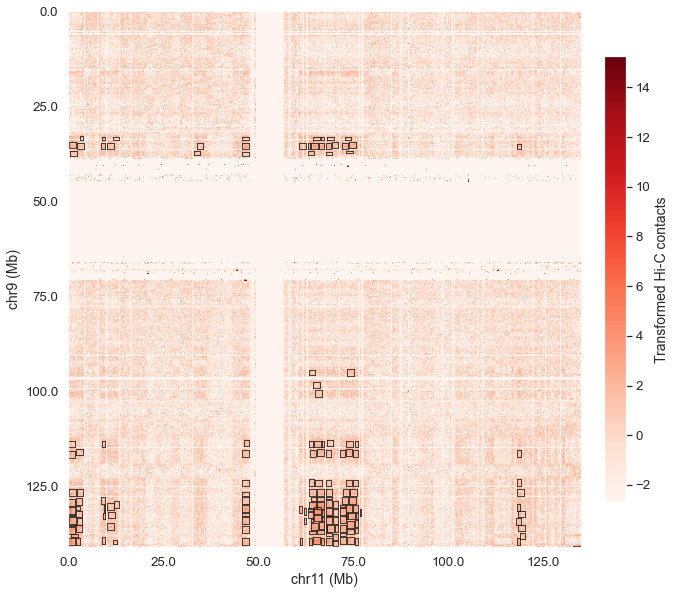

In [63]:
# Draw LAS clusters

def map_pos2rownum(df, row_pos):
    return np.where(df.index.values == row_pos)[0][0]
def map_pos2colnum(df, row_pos):
    return np.where(df.columns.values == str(int(row_pos)))[0][0]
def map_rownum2pos(df, row_num):
    positions = df.index.values
    return positions[row_num]
def map_colnum2pos(df, col_num):
    positions = df.columns.values
    return float(positions[col_num])

def draw_identified_LASregions(pair, minl, maxl):
    chr1, chr2 = pair
    plt.rc('font', family='serif')
    sns.set_style("dark", {'axes.grid':False})
    
    # Load and plot HiC data
    hic_filename =  dir_processed_hic+f'hic_chr{chr1}_chr{chr2}_zscore.txt'
    df = pd.read_csv(hic_filename, index_col = 0)
    data = df.values
    plt.figure(figsize=(10,10))
    im = plt.imshow(data, cmap = 'Reds', vmin = minl, vmax = maxl)
    cbar = plt.colorbar(fraction=0.04, pad=0.04)
    cbar.set_label('Transformed Hi-C contacts', fontsize = 14)
    cbar.solids.set_rasterized(True) 

    # Label ticks with genomic position (Mb)
    xaxis = range(0, df.shape[1], 100)
    xlabels = [str(map_colnum2pos(df, x)/1000000.0) for x in xaxis]
    plt.xticks(xaxis, xlabels)
    yaxis = range(0, df.shape[0], 100)
    ylabels = [str(map_rownum2pos(df, y)/1000000.0) for y in yaxis]
    plt.yticks(yaxis, ylabels)
    plt.xlabel('chr' + str(chr2) + ' (Mb)', fontsize = 14)
    plt.ylabel('chr' + str(chr1) + ' (Mb)', fontsize = 14)

    # Load and plot LAS clusters
    filename = dir_las+f'intermingling_regions.chr{chr1}_chr{chr2}.avg_filt.csv'
    df_intermingling = pd.read_csv(filename, index_col = 0)
    # iterate over all las regions found
    for num in range(0, len(df_intermingling)):
        region = df_intermingling.iloc[num]
        start_row = map_pos2rownum(df, region['start row'])
        stop_row = map_pos2rownum(df, region['stop row'])
        start_col = map_pos2colnum(df, region['start col'])
        stop_col = map_pos2colnum(df, region['stop col'])

        # draw vertical lines - columns are same
        plt.plot([start_col, start_col], [start_row, stop_row], 'k-', lw = 0.8)
        plt.plot([stop_col, stop_col], [start_row, stop_row], 'k-', lw = 0.8)
        # draw horizontal lines - rows are same
        plt.plot([start_col, stop_col], [start_row, start_row], 'k-', lw = 0.8)
        plt.plot([start_col, stop_col], [stop_row, stop_row], 'k-', lw = 0.8)

#     plt.savefig(saving_main_dir+f'fig_X.pdf', format='pdf')
#     plt.hlines(y=534, xmin=0, xmax=500)
#     plt.vlines(x=250, ymin=0, ymax=600)
    plt.show()
    
pair = (chr1, chr2)
draw_identified_LASregions(pair, min_hic, max_hic)

### b. Show that LAS matrices are significant

In [28]:
# Compute total number of hypotheses

max_matrix_size = 8 # (40 = 10Mb, 8 = 2Mb)
alpha = 0.0001

chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
n_hyp = 0
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair
    
    # Load HiC data to check chromosome size
    hic_filename =  dir_processed_hic+f'hic_chr{chr1}_chr{chr2}_zscore.txt'
    df = pd.read_csv(hic_filename, index_col = 0)
    n1, n2 = df.shape
    
    for k,l in itertools.product(range(max_matrix_size), range(max_matrix_size)):
        n_hyp = n_hyp+(n1-k+1)*(n2-l+1)
    
print(f'Total number of hypotheses = {n_hyp}')
print(f'P-value threshold for FWER control at {alpha} = {alpha/n_hyp}')

100%|██████████| 231/231 [00:16<00:00, 14.02it/s]

Total number of hypotheses = 3990387344
P-value threshold for FWER control at 0.0001 = 2.5060223827734756e-14


In [29]:
# Loop over all chromosome pairs to collect LAS score and compute p-value

def create_region_name(chr1, chr2, row):
    out = f"chr{chr1}_{int(row['start row']//resol)}_{int(row['stop row']//resol)}"
    out = out+f"_chr{chr2}_{int(row['start col']//resol)}_{int(row['stop col']//resol)}"
    return out

def compute_las_pval(n1, n2, resol, row):
    k = (row['stop row']-row['start row'])//resol
    l = (row['stop col']-row['start col'])//resol
    
#     # If we consider all k-by-l matrices
#     cnr = gammaln(n1 + 1) - gammaln(k+1) - gammaln(n1-k+1)
#     cnc = gammaln(n2 + 1) - gammaln(l+1) - gammaln(n2-l+1)
#     neglogpval = row['score']+cnr+cnc
    
    # If we consider only contiguous k-by-l matrices
    neglogpval = row['score']+np.log(n1-k+1)+np.log(n2-l+1)
    
    return(neglogpval)

chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
las_scores_ls = []
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair
    
    # Load HiC data to check chromosome size
    hic_filename =  dir_processed_hic+f'hic_chr{chr1}_chr{chr2}_zscore.txt'
    df = pd.read_csv(hic_filename, index_col = 0)
    n1, n2 = df.shape
    
    # Load intermingling regions
    filename = dir_las+f'intermingling_regions.chr{chr1}_chr{chr2}.avg_filt.csv'
    las = pd.read_csv(filename, header=0, index_col=0, sep=',')
    if las.shape[0]>0:
        las['region'] = las.apply(
            lambda row: create_region_name(chr1, chr2, row), axis=1
        )
        las['neglogpval'] = las.apply(
            lambda row: compute_las_pval(n1, n2, resol, row), axis=1
        )
        las = las[['region', 'score', 'neglogpval']]
        las_scores_ls.append(las)

las_scores_df = pd.concat(las_scores_ls, axis=0)
las_scores_df = las_scores_df.reset_index(drop=True)

100%|██████████| 231/231 [00:17<00:00, 12.85it/s]


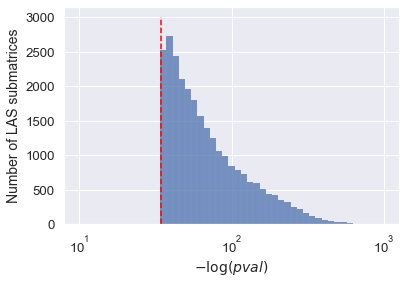

In [30]:
# Plot distribution of LAS scores
sns.set(font_scale=1.2)
plt.figure()
sns.histplot(las_scores_df['neglogpval'], bins=np.logspace(1,3,50))
plt.vlines(x=-np.log(1-0.999999999999999), ymin=0, ymax=3000, color='red', linestyle='dashed')
plt.xscale('log')
plt.xlabel(r"$-\log(pval)$", fontsize=14)
plt.ylabel('Number of LAS submatrices', fontsize=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', format='pdf')
plt.show()

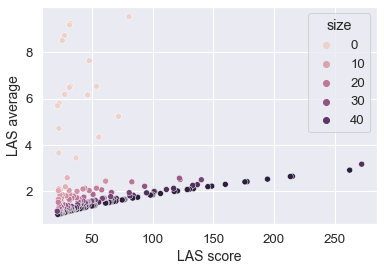

In [31]:
# Look at relationship between LAS score and average
chr1, chr2 = 1, 2
intermingling_regions_chr1chr2_fname = dir_las+f'intermingling_regions.chr{chr1}_chr{chr2}.avg_filt.csv'
intermingling_regions_chr1chr2 = pd.read_csv(intermingling_regions_chr1chr2_fname, 
                                             header=0, index_col=0, sep=',')
intermingling_regions_chr1chr2['size'] = (intermingling_regions_chr1chr2['stop row']-intermingling_regions_chr1chr2['start row'])*(intermingling_regions_chr1chr2['stop col']-intermingling_regions_chr1chr2['start col'])//(resol**2)

sns.set(font_scale=1.2)
plt.figure()
sns.scatterplot(data=intermingling_regions_chr1chr2, x='score', y='avg', hue='size')
plt.xlabel('LAS score', size=14)
plt.ylabel('LAS average', size=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', format='pdf')
plt.show()

### c. Show LAS clusters on active adhesome Hi-C matrix

In [32]:
# Define active adhesome loci as the loci of active adhesome genes
active_adhesome_loci = [gene2locus[g] for g in active_adhesome_genes]
active_adhesome_loci = list(itertools.chain.from_iterable(active_adhesome_loci))
active_adhesome_tf_loci = [gene2locus[g] for g in active_lung_adhesome_tf_genes]
active_adhesome_tf_loci = list(itertools.chain.from_iterable(active_adhesome_tf_loci))
loci_list = active_adhesome_loci+active_adhesome_tf_loci
loci_list = np.unique(loci_list)

In [33]:
# Order loci in genomic order
loci_order_df = pd.DataFrame({'locus_id': loci_list})
loci_order_df['chrom'] = loci_order_df['locus_id'].str.split('_', expand=True)[1].astype(int)
loci_order_df['loc'] = loci_order_df['locus_id'].str.split('_', expand=True)[3].astype(int)
loci_order_df = loci_order_df.sort_values(by=['chrom', 'loc'])
loci_list = loci_order_df['locus_id'].values.tolist()

In [34]:
# Load Hi-C matrix of active adhesome loci
contacts_df = pd.DataFrame(np.nan, index=loci_list, columns=loci_list)
all_las_clusters = []
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair
    
    # Select Hi-C values
    hic_filename = dir_processed_hic+f'hic_chr{chr1}_chr{chr2}_zscore.txt'
    df = pd.read_csv(hic_filename, index_col = 0)
    df.columns = df.columns.astype(int)
    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr1_num = [int(locus.split('_')[3]) for locus in loci_chr1]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]
    loci_chr2_num = [int(locus.split('_')[3]) for locus in loci_chr2]
    # Update contacts_df
    contacts_df.loc[loci_chr1, loci_chr2] = df.loc[loci_chr1_num, loci_chr2_num].values
    contacts_df.loc[loci_chr2, loci_chr1] = df.loc[loci_chr1_num, loci_chr2_num].values.T
    
    # Load intermingling regions
    filename = dir_las+f'intermingling_regions.chr{chr1}_chr{chr2}.avg_filt.csv'
    las = pd.read_csv(filename, header=0, index_col=0, sep=',')
    if las.shape[0]>0:
        # Determine which loci cluster together
        las['loci_chr1'] = las.apply(
            lambda row: np.arange(row[0], row[1]+1, resol).astype(int).tolist(), axis=1
        )
        las['loci_chr1'] = las['loci_chr1'].apply(
            lambda ls: [f'chr_{chr1}_loc_{loc}' for loc in ls]
        )
        las['loci_chr2'] = las.apply(
            lambda row: np.arange(row[2], row[3]+1, resol).astype(int).tolist(), axis=1
        )
        las['loci_chr2'] = las['loci_chr2'].apply(
            lambda ls: [f'chr_{chr2}_loc_{loc}' for loc in ls]
        )
        # Select adhesome loci specifically
        las['adhesome_loci_chr1'] = las['loci_chr1'].apply(
            lambda ls: [loc for loc in ls if (loc in loci_chr1)]
        )
        las['adhesome_loci_chr2'] = las['loci_chr2'].apply(
            lambda ls: [loc for loc in ls if (loc in loci_chr2)]
        )
        # Provide the index in loci_list corresponding to each adhesome locus
        las['adhesome_loci_index_chr1'] = las['adhesome_loci_chr1'].apply(
            lambda ls: [loci_list.index(loc) for loc in ls]
        )
        las['adhesome_loci_index_chr2'] = las['adhesome_loci_chr2'].apply(
            lambda ls: [loci_list.index(loc) for loc in ls]
        )
        # Only keep lines if adhesome cluster
        las['adhesome_cluster'] = las.apply(
            lambda row: ((len(row[10])>0) & (len(row[11])>0)), axis=1
        )
        las = las[las['adhesome_cluster']==True]
        las = las[['adhesome_loci_chr1', 
                   'adhesome_loci_chr2', 
                   'adhesome_loci_index_chr1', 
                   'adhesome_loci_index_chr2'
                  ]]
        # Add to list of all LAS clusters
        all_las_clusters.append(las)

las_clusters_df = pd.concat(all_las_clusters, axis=0)

100%|██████████| 231/231 [00:21<00:00, 10.54it/s]


In [35]:
# Merge overlapping clusters
las_clusters_merged_list = []

for las in tqdm(all_las_clusters):
    
    # List all LAS clusters for that chromosome pair
    new_las_list = [las.loc[i,['adhesome_loci_index_chr1', 'adhesome_loci_index_chr2']].tolist() for i in las.index]
    
    # If only zero or one cluster, no need to merge
    if len(new_las_list) == 0:
        continue
    
    if len(new_las_list) == 1:
        new_las = pd.DataFrame(new_las_list, columns=['adhesome_loci_index_chr1', 'adhesome_loci_index_chr2'])
        las_clusters_merged_list.append(new_las)
        continue
    
    # Merge overlapping/adjacent clusters
    i = 0
    j = i+1
    flag = True
    while flag:

        loci_idx_chr1 = set(new_las_list[i][0])
        loci_idx_chr2 = set(new_las_list[i][1])

        loci_idx_chr1_other = set(new_las_list[j][0])
        loci_idx_chr2_other = set(new_las_list[j][1])

        row_intersect = sorted(set.intersection(*[loci_idx_chr1, loci_idx_chr1_other]))
        col_intersect = sorted(set.intersection(*[loci_idx_chr2, loci_idx_chr2_other]))

        row_union = sorted(set.union(*[loci_idx_chr1, loci_idx_chr1_other]))
        col_union = sorted(set.union(*[loci_idx_chr2, loci_idx_chr2_other]))

        merge_criterion_1 = (len(row_intersect)>0) & (len(col_intersect)>0)
        merge_criterion_2 = (len(row_union)==len(row_intersect)) & (max(loci_idx_chr2)+1==min(loci_idx_chr2_other))
        merge_criterion_3 = (len(row_union)==len(row_intersect)) & (max(loci_idx_chr2_other)+1==min(loci_idx_chr2))
        merge_criterion_4 = (len(col_union)==len(col_intersect)) & (max(loci_idx_chr1)+1==min(loci_idx_chr1_other))
        merge_criterion_5 = (len(col_union)==len(col_intersect)) & (max(loci_idx_chr1_other)+1==min(loci_idx_chr1))

        if (merge_criterion_1 | merge_criterion_2 | merge_criterion_3 | merge_criterion_4 | merge_criterion_5):
            new_las_list[i] = [row_union, col_union]
            new_las_list.remove(new_las_list[j])
            if ((i+1)<len(new_las_list)-2) & (j>len(new_las_list)-1):
                i = i+1
                j = i+1
            elif (i>=len(new_las_list)-2) & (j>len(new_las_list)-1):
                flag = False
            else:
                j = i+1

        elif ((j+1)<len(new_las_list)-1):
            j = j+1

        elif ((i+1)<len(new_las_list)-2):
            i = i+1
            j = i+1

        else:
            flag = False
    
    # Cast as dataframe
    new_las = pd.DataFrame(new_las_list, columns=['adhesome_loci_index_chr1', 'adhesome_loci_index_chr2'])
    las_clusters_merged_list.append(new_las)
    
# Concatenate dataframes for all chromosome pairs
las_clusters_df_merged = pd.concat(las_clusters_merged_list, axis=0)
las_clusters_df_merged = las_clusters_df_merged.reset_index(drop=True)

100%|██████████| 231/231 [00:01<00:00, 157.48it/s]


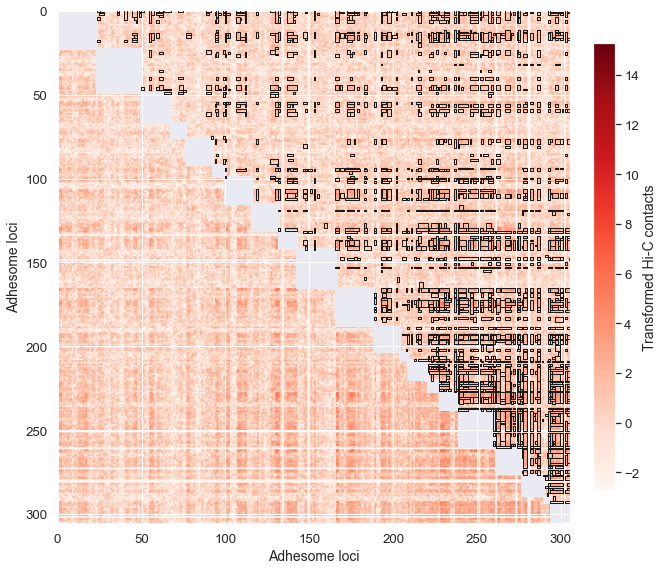

In [36]:
# Visualize LAS adhesome clusters
plt.figure(figsize=(10,10))
plt.imshow(contacts_df, cmap = 'Reds', vmin = min_hic, vmax = max_hic, interpolation=None)
cbar = plt.colorbar(fraction=0.04, pad=0.04)
cbar.set_label('Transformed Hi-C contacts', fontsize = 14)
cbar.solids.set_rasterized(True) 
# plt.xticks(np.arange(0, contacts_df.shape[1], 50), fontsize=14)
# plt.yticks(np.arange(0, contacts_df.shape[0], 50), fontsize=14)
plt.xlabel('Adhesome loci', fontsize = 14)
plt.ylabel('Adhesome loci', fontsize = 14)

# Plot LAS clusters
delta = 0.5
lw = 1
for num in range(0, len(las_clusters_df_merged)):
    start_row = las_clusters_df_merged.iloc[num,:]['adhesome_loci_index_chr1'][0]-delta
    stop_row = las_clusters_df_merged.iloc[num,:]['adhesome_loci_index_chr1'][-1]+delta
    start_col = las_clusters_df_merged.iloc[num,:]['adhesome_loci_index_chr2'][0]-delta
    stop_col = las_clusters_df_merged.iloc[num,:]['adhesome_loci_index_chr2'][-1]+delta

    # draw vertical lines - columns are same
    plt.plot([start_col, start_col], [start_row, stop_row], 'k-', lw = lw)
    plt.plot([stop_col, stop_col], [start_row, stop_row], 'k-', lw = lw)
    # draw horizontal lines - rows are same
    plt.plot([start_col, stop_col], [start_row, start_row], 'k-', lw = lw)
    plt.plot([start_col, stop_col], [stop_row, stop_row], 'k-', lw = lw)

# plt.savefig(dir_las+f'fig_X.pdf', format='pdf')
plt.show()

# 2. LAS cluster graph

### a. Construct cluster graph

In [19]:
# Helper function to contract nodes of graph

def contracted_nodes(G, node_list, adj_weights=['avg', 'score']):
    """Helper function to contract nodes of graph
    """
    # Copying has significant overhead and can be disabled if needed
    H = G.copy()
    old_nodes = sorted(H.nodes)
    new_Gs = {}
    new_attributes = {}
    
    # Create dictionary mapping old nodes to the new contracted nodes
    oldnode2newnode = {}
    for old_node in old_nodes:
        # Check if old node is contained in a super node
        for new_node in node_list:
            if (old_node in new_node):
                new_node_name = ', '.join(sorted(set(itertools.chain.from_iterable([x.split(', ') 
                                                                                    for x in new_node]))))
                oldnode2newnode[old_node] = new_node_name
                break
            oldnode2newnode[old_node] = old_node

    for adj_weight in adj_weights:
        # Zero out edges within supernodes
        adj_df = nx.to_pandas_adjacency(H, nodelist=old_nodes, weight=adj_weight)
        for supernode in node_list:
            adj_df.loc[supernode, supernode] = 0

        # Define new index
        old_index = adj_df.index.values
        new_index = [oldnode2newnode[old_node] for old_node in old_index]
        adj_df.index = new_index
        adj_df.columns = new_index

        # Groupby new index
        grouper = adj_df.index
        adj_df = adj_df.groupby(grouper, sort=False, axis=0).mean()
        adj_df = adj_df.groupby(grouper, sort=False, axis=1).mean()

        # Revert to graph
        new_Gs[adj_weight] = nx.from_pandas_adjacency(adj_df)
        new_attributes[adj_weight] = nx.get_edge_attributes(new_Gs[adj_weight], 'weight')
        
    # Create new graph
    new_G = nx.from_pandas_adjacency((adj_df>0).astype(int))
    for adj_weight in adj_weights:
        nx.set_edge_attributes(new_G, new_attributes[adj_weight], name = adj_weight)
    
    return(new_G)

In [20]:
# For each chromosome pair and each intermingling region, create a graph and edge list

def create_las_graph(dir_las, gene_list, tf_gene_list):

    combined_gene_list = np.unique(gene_list+tf_gene_list).tolist()
    
    chr_list = np.arange(1,23,1)
    chr_pairs = list(itertools.combinations(chr_list, 2))

    node_attribute_chrom = {}
    edge_lists = []

    for chr1, chr2 in tqdm(chr_pairs):

        # Load intermingling regions
        intermingling_regions_chr1chr2_fname = dir_las+f'intermingling_regions.chr{chr1}_chr{chr2}.avg_filt.csv'
        intermingling_regions_chr1chr2 = pd.read_csv(intermingling_regions_chr1chr2_fname, 
                                                     header=0, index_col=0, sep=',')

        if len(intermingling_regions_chr1chr2)==0:
#             print(f'Chromosomes {chr1} and {chr2} do not have intermingling regions')
            pass
        else:
            # Sort regions by LAS average value
            intermingling_regions_chr1chr2 = intermingling_regions_chr1chr2.sort_values(by=['avg'], ascending=False)

            # For each intermingling region, list loci on chr1 and chr2
            intermingling_regions_chr1chr2['loci_chr1'] = intermingling_regions_chr1chr2.apply(
                lambda row: np.arange(row[0], row[1]+1, resol).astype(int), axis=1
            )
            intermingling_regions_chr1chr2['loci_chr1'] = intermingling_regions_chr1chr2['loci_chr1'].apply(
                lambda loci: [f'chr_{chr1}_loc_{loc}' for loc in loci]
            )
            intermingling_regions_chr1chr2['loci_chr2'] = intermingling_regions_chr1chr2.apply(
                lambda row: np.arange(row[2], row[3]+1, resol).astype(int), axis=1
            )
            intermingling_regions_chr1chr2['loci_chr2'] = intermingling_regions_chr1chr2['loci_chr2'].apply(
                lambda loci: [f'chr_{chr2}_loc_{loc}' for loc in loci]
            )

            # List adhesome gene in loci_chr1 and loci_chr2
            intermingling_regions_chr1chr2['adhesome_chr1'] = intermingling_regions_chr1chr2['loci_chr1'].apply(
                lambda loci: sorted(itertools.chain.from_iterable([[g for g in locus2gene[loc] 
                               if (g in combined_gene_list)] for loc in loci if (loc in locus2gene.keys())]))
            )
            intermingling_regions_chr1chr2['adhesome_chr2'] = intermingling_regions_chr1chr2['loci_chr2'].apply(
                lambda loci:  sorted(itertools.chain.from_iterable([[g for g in locus2gene[loc] 
                               if (g in combined_gene_list)] for loc in loci if (loc in locus2gene.keys())]))
            )

            # Name cluster 1 and 2 by their genes
            intermingling_regions_chr1chr2['source'] = intermingling_regions_chr1chr2['adhesome_chr1'].apply(
                lambda gene_list: ', '.join(sorted(set(gene_list)))  
            )
            intermingling_regions_chr1chr2['target'] = intermingling_regions_chr1chr2['adhesome_chr2'].apply(
                lambda gene_list: ', '.join(sorted(set(gene_list)))  
            )

            # Only keep relationships between clusters containing adhesome genes
            intermingling_regions_chr1chr2 = intermingling_regions_chr1chr2[
                (intermingling_regions_chr1chr2['source'] != '') & (intermingling_regions_chr1chr2['target'] != '')
            ]

            # Create edge list
            intermingling_regions_chr1chr2 = intermingling_regions_chr1chr2[['source', 'target', 'avg', 'score']]
            edge_lists.append(intermingling_regions_chr1chr2)
            for source in intermingling_regions_chr1chr2['source']:
                node_attribute_chrom[source] = 'chr'+str(chr1)
            for target in intermingling_regions_chr1chr2['target']:
                node_attribute_chrom[target] = 'chr'+str(chr2)
            
    # Create final edge list and graph
    edge_list = pd.concat(edge_lists, axis=0)
    G = nx.from_pandas_edgelist(df=edge_list, source='source', target='target', edge_attr=['avg', 'score'])
    nx.set_node_attributes(G, node_attribute_chrom, 'chrom')
    
    # Determine nodes that have at least one gene in common
    nodes = list(G.nodes)
    common_genes = pd.DataFrame(0, index=nodes, columns=nodes)
    for node1, node2 in itertools.combinations(nodes, 2):
        node1_ls = node1.split(', ')
        node2_ls = node2.split(', ')
        common_genes.loc[node1, node2] = len(set.intersection(*[set(node1_ls), set(node2_ls)]))
    G_common = nx.from_pandas_adjacency(common_genes>0) 
    supernodes = list(nx.connected_components(G_common))
    
    # Contract nodes
    G = contracted_nodes(G, supernodes, adj_weights=['avg', 'score'])
    
    # Determine chromosome of supernodes
    supernode_attribute_chrom = {}
    for supernode in G.nodes:
        gene_in_supernode = supernode.split(', ')[0]
        supernode_attribute_chrom[supernode] = gene2chrom[gene_in_supernode]
    
    # Add node metadata
    nx.set_node_attributes(G, supernode_attribute_chrom,'chrom')
    nx.set_node_attributes(G, {node: node.split(', ') for node in G.nodes},'genes')
    
    return(G)

In [284]:
# Create LAS graph for adhesome genes
G = create_las_graph(dir_las, active_adhesome_genes.tolist(), active_lung_adhesome_tf_genes.tolist())
# Annotate nodes containing a TF
tf_dict = {k: str(len(set.intersection(*[set(v['genes']), set(active_lung_adhesome_tf_genes)]))>0) 
           for k,v in dict(G.nodes(data=True)).items()}
nx.set_node_attributes(G, tf_dict, 'Transcription factor')
print(nx.info(G))
print(f'Density: {nx.density(G)}')

100%|██████████| 231/231 [00:07<00:00, 30.43it/s]


Name: 
Type: Graph
Number of nodes: 128
Number of edges: 2837
Average degree:  44.3281
Density: 0.3490403543307087


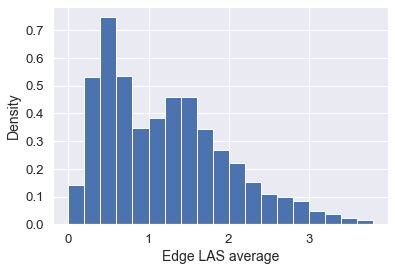

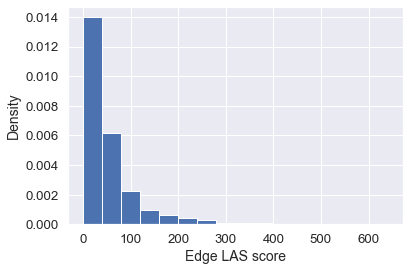

In [22]:
# Distribution of edge weights
edge_weights = list(nx.get_edge_attributes(G, 'avg').values())
sns.set(font_scale=1.2)
plt.figure()
plt.hist(edge_weights, density=True, bins = np.arange(0, 4, 0.2))
plt.xlabel('Edge LAS average', fontsize=14)
plt.ylabel('Density', fontsize=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

# Distribution of edge weights
edge_weights = list(nx.get_edge_attributes(G, 'score').values())
plt.figure()
plt.hist(edge_weights, density=True, bins = np.arange(0, 650, 40))
plt.xlabel('Edge LAS score', fontsize=14)
plt.ylabel('Density', fontsize=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

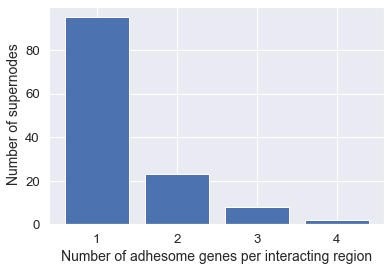

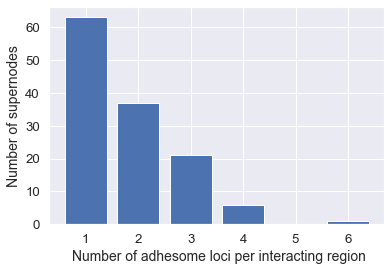

In [23]:
# Distribution of number of genes/loci per adhesome supernode
n_genes_per_node = [len(supernode.split(', ')) for supernode in G.nodes]
n_loci_per_node = [len(set(itertools.chain.from_iterable([gene2locus[g] 
                                                          for g in supernode.split(', ')]))) 
                   for supernode in G.nodes]

sns.set(font_scale=1.2)
x, h = np.unique(n_genes_per_node, return_counts=True)
plt.figure()
plt.bar(x, h)
plt.xlabel('Number of adhesome genes per interacting region', fontsize=14)
plt.ylabel(' Number of supernodes', fontsize=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

sns.set(font_scale=1.2)
x, h = np.unique(n_loci_per_node, return_counts=True)
plt.figure()
plt.bar(x, h)
plt.xlabel(' Number of adhesome loci per interacting region', fontsize=14)
plt.ylabel('Number of supernodes', fontsize=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

### b. Compare to random LAS graphs

In [24]:
# Create list of active non adhesome genes
n_adhesome = len(active_adhesome_genes)+len(active_lung_adhesome_tf_genes)
active_non_adhesome_genes = set(active_genes)-set(active_adhesome_genes)-set(active_lung_adhesome_tf_genes)
active_non_adhesome_genes = list(active_non_adhesome_genes)

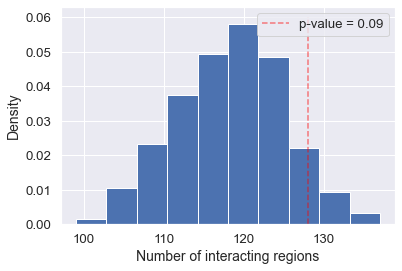

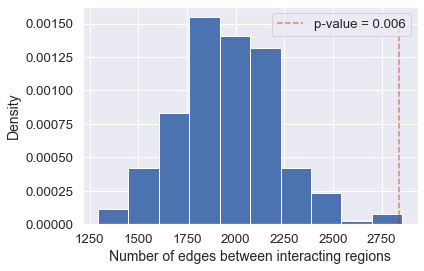

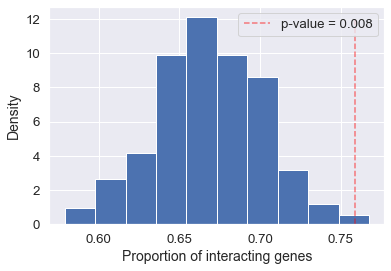

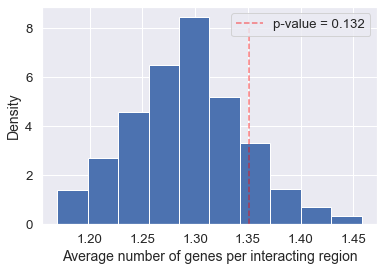

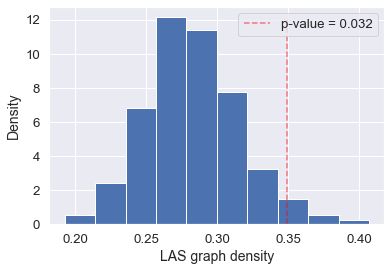

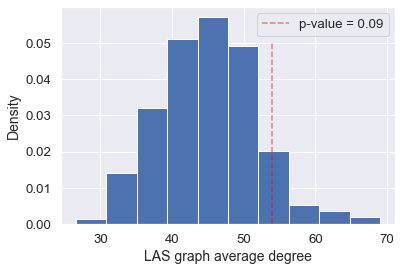

In [25]:
# Plot descriptive statistics

n_rep = 500

with open(saving_dir+'las_graph_significance.pkl', 'rb') as f:
    out = pickle.load(f)
graph_nnodes = out[:,0]
graph_nedges = out[:,1]
graph_ngeneskept = out[:,2]
graph_meangenes = out[:,3]
graph_densities = out[:,4]
graph_avg_degrees = out[:,5]

sns.set(font_scale=1.2)
x = len(G.nodes)
pval = np.round(((np.sum(graph_nnodes>=x)+1)/(n_rep+1)), 3)
plt.figure()
plt.hist(graph_nnodes, density=True)#, bins=np.arange(0.15, 0.6, 0.01))
plt.vlines(x=x, ymin=0, ymax=0.06, color='red', linestyle='dashed', alpha=0.5, label=f'p-value = {pval}')
plt.xlabel('Number of interacting regions', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper right')
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

sns.set(font_scale=1.2)
x = len(G.edges)
pval = np.round(((np.sum(graph_nedges>=x)+1)/(n_rep+1)), 3)
plt.figure()
plt.hist(graph_nedges, density=True)#, bins=np.arange(0.15, 0.6, 0.01))
plt.vlines(x=x, ymin=0, ymax=0.00150, color='red', linestyle='dashed', alpha=0.5, label=f'p-value = {pval}')
plt.xlabel('Number of edges between interacting regions', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper right')
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

sns.set(font_scale=1.2)
x = len(set(itertools.chain.from_iterable([node.split(', ') for node in G.nodes])))/n_adhesome
pval = np.round(((np.sum(graph_ngeneskept/n_adhesome>=x)+1)/(n_rep+1)), 3)
plt.figure() #figsize=(6,8)
plt.hist(graph_ngeneskept/n_adhesome, density=True)#, bins=np.arange(0, 1.01, 0.05))
plt.vlines(x=x, ymin=0, ymax=12, color='red', linestyle='dashed', alpha=0.5, label=f'p-value = {pval}')
plt.xlabel('Proportion of interacting genes', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper right')
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

sns.set(font_scale=1.2)
x = np.mean([len(node.split(', ')) for node in G.nodes])
pval = np.round(((np.sum(graph_meangenes>=x)+1)/(n_rep+1)), 3)
plt.figure()
plt.hist(graph_meangenes, density=True)#, bins=np.arange(0.15, 0.6, 0.01))
plt.vlines(x=x, ymin=0, ymax=8, color='red', linestyle='dashed', alpha=0.5, label=f'p-value = {pval}')
plt.xlabel('Average number of genes per interacting region', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper right')
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

sns.set(font_scale=1.2)
x = nx.density(G)
pval = np.round(((np.sum(graph_densities>=x)+1)/(n_rep+1)), 3)
plt.figure()
plt.hist(graph_densities, density=True)#, bins=np.arange(0.15, 0.6, 0.01))
plt.vlines(x=x, ymin=0, ymax=12, color='red', linestyle='dashed', alpha=0.5, label=f'p-value = {pval}')
plt.xlabel('LAS graph density', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper right')
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

sns.set(font_scale=1.2)
x = np.mean(list(dict(nx.degree(G, weight='avg')).values()))
pval = np.round(((np.sum(graph_avg_degrees>=x)+1)/(n_rep+1)), 3)
plt.figure()
plt.hist(graph_avg_degrees, density=True)#, bins=np.arange(0, 70, 2))
plt.vlines(x=x, ymin=0, ymax=0.05, color='red', linestyle='dashed', alpha=0.5, label=f'p-value = {pval}')
plt.xlabel('LAS graph average degree', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper right')
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

### b. Overlay LAS graph with regulatory marks

In [26]:
# Load regulatory marks
df_all_norm = pd.read_csv(saving_dir+'features_matrix_all_genes_norm.csv', header=0, index_col=0)

In [27]:
# Coregulation of adhesome genes
selected_genes = np.unique(np.concatenate([active_adhesome_genes, active_lung_adhesome_tf_genes]))
df_adhesome = df_all_norm.T.loc[selected_genes,:]
R_adhesome = df_adhesome.T.corr(method='spearman')

In [285]:
# Examine edges of G
edge_data = oi.get_networkx_graph_as_dataframe_of_edges(G)
column_renaming_dict = {'protein1': 'source',
                        'protein2': 'target',
                        'weight': 'weight',
                        'score': 'score',
                        'avg': 'avg'}
edge_data = edge_data.rename(columns=column_renaming_dict)
edge_data['source_genes'] = edge_data['source'].str.split(', ')
edge_data['target_genes'] = edge_data['target'].str.split(', ')

def cross_corr(genes1, genes2, R_adhesome):
    corr = R_adhesome.loc[genes1, genes2].mean().mean()
    return(corr)

edge_data['reg_corr'] = edge_data.apply(
    lambda row: cross_corr(row['source_genes'], row['target_genes'], R_adhesome), axis=1
)
regcorr_dict = {(edge_data.loc[i, 'source'], edge_data.loc[i, 'target']): edge_data.loc[i, 'reg_corr']
                for i in edge_data.index}
nx.set_edge_attributes(G, regcorr_dict, 'reg_corr')

<Figure size 432x288 with 0 Axes>

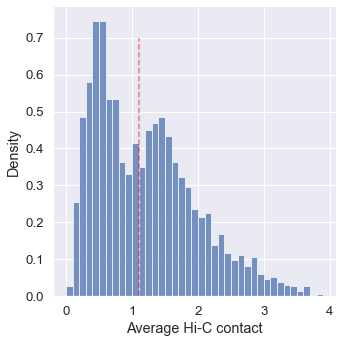

In [29]:
# Pick a threshold for LAS 
variable = 'avg'
t_las = np.quantile(edge_data[variable].values, 0.5)

sns.set(font_scale=1.2)
plt.figure()
g = sns.displot(edge_data, x=variable, stat='density', bins=np.arange(0, 4, 0.1))
plt.vlines(x=t_las, ymin=0, ymax=0.7, color='red', linestyle='dashed', alpha=0.5)
plt.xlabel(f'Average Hi-C contact')
plt.ylabel('Density')
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

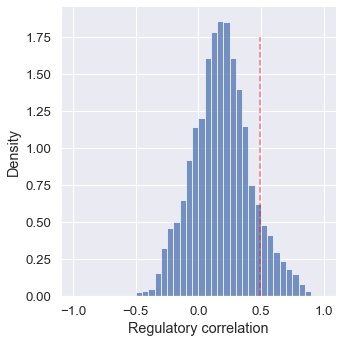

In [30]:
# Pick a threshold for correlation 
t_corr = np.quantile(edge_data['reg_corr'].values, 0.9)

sns.set(font_scale=1.2)
plt.figure()
g = sns.displot(edge_data, x='reg_corr', stat='density', bins=np.arange(-1,1.01,0.05))
plt.vlines(x=t_corr, ymin=0, ymax=1.75, color='red', linestyle='dashed', alpha=0.5)
plt.xlabel(f'Regulatory correlation')
plt.ylabel('Density')
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

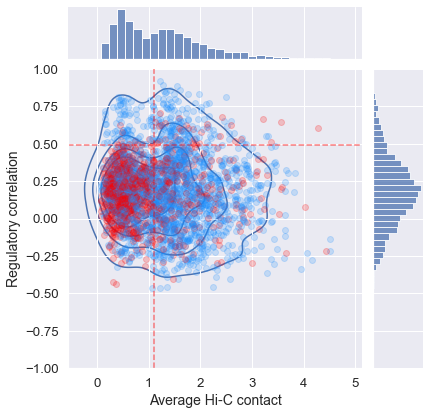

In [31]:
# Visualize LAS score and regulatory correlation

# List and count number of TFs in edges
tf_set = set(active_lung_adhesome_tf_genes)
edge_data['n_TFs'] = edge_data.apply(
    lambda row: len(set.intersection(*[tf_set, set(row['source_genes'])]))+
    len(set.intersection(*[tf_set, set(row['target_genes'])])), axis=1
)
edge_data['TF'] = edge_data.apply(
    lambda row: 'TF edge' if len(set.intersection(*[tf_set, set(row['source_genes'])]))+
    len(set.intersection(*[tf_set, set(row['target_genes'])]))>0 else 'no TF', axis=1
)
edge_data['TF_edge'] = edge_data.apply(
    lambda row: list(set.intersection(*[tf_set, set(row['source_genes'])]))+
    list(set.intersection(*[tf_set, set(row['target_genes'])])), axis=1
)
colors = ['red' if tf=='TF edge' else 'dodgerblue' for tf in edge_data['TF']]

edge_data = edge_data[['source', 'source_genes', 'target', 'target_genes', 'weight', 'avg', 
                      'score', 'reg_corr', 'n_TFs', 'TF', 'TF_edge']]

# Plot 2D distribution and scatterplot
sns.set(font_scale=1.2)
plt.figure()
g = sns.jointplot(data=edge_data, x=variable, y='reg_corr', alpha=0)
for i,row in enumerate(edge_data.values):
    g.ax_joint.plot(row[5], row[7], color=colors[i], marker='o', alpha=0.2)
g.plot_joint(sns.kdeplot, zorder=0, n_levels=6)

g.ax_joint.axvline(x=t_las, color='red', linestyle='dashed', alpha=0.5)
g.ax_joint.axhline(y=t_corr, color='red', linestyle='dashed', alpha=0.5)
g.set_axis_labels(f'Average Hi-C contact', 'Regulatory correlation', fontsize=14)
plt.ylim([-1,1])
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

In [32]:
# Are TFs enriched in the upper right quadrant?
k = edge_data[(edge_data['avg']>t_las) & 
              (edge_data['reg_corr']>t_corr) &
              (edge_data['n_TFs']>0)].shape[0] # total number of TF edges in upper left quadrant
M = edge_data.shape[0] # total number of edges
n = edge_data[edge_data['n_TFs']>0].shape[0] # total number of TF edges
N = edge_data[(edge_data['avg']>t_las) & 
              (edge_data['reg_corr']>t_corr)].shape[0] # total number of edges in upper quadrant
pval = ss.hypergeom.sf(k, M, n, N, loc=0)
print(f'Hypergeometric p-value = {pval}')

Hypergeometric p-value = 0.9999919217254312


100%|██████████| 1000/1000 [00:01<00:00, 547.42it/s]


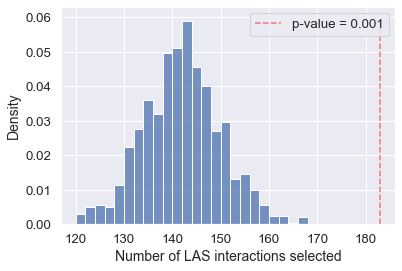

In [33]:
# Statistical significance on the size of edges above the LAS average and Regulatory correlation score

# Null distribution
n_rep = 1000
n_selected_list = []
for i in tqdm(range(n_rep)):
    
    # First, copy edge list
    edge_data_copy = edge_data.copy()
    edge_data_copy = edge_data_copy[['source', 'target', 'avg', 'score', 'reg_corr']]
    
    # Then, randomly permute regulatory correlation column
    np.random.seed(i**2)
    len_edge_data = edge_data_copy.shape[0]
    permutation = np.random.permutation(len_edge_data)
    edge_data_copy['reg_corr'] = edge_data_copy['reg_corr'][permutation].values
    
    # Then compute number of edges above threshold
    edge_data_copy = edge_data_copy[(edge_data_copy[variable]>t_las) & (edge_data_copy['reg_corr']>t_corr)]
    n_selected = edge_data_copy.shape[0]
    n_selected_list.append(n_selected)
n_selected_list = np.array(n_selected_list)

# Test statistic and p_value
edge_data_copy = edge_data.copy()
edge_data_copy = edge_data_copy[(edge_data_copy[variable]>t_las) & (edge_data_copy['reg_corr']>t_corr)]
T = edge_data_copy.shape[0]
pval = np.round((np.sum(n_selected_list>=T)+1)/(n_rep+1), 3)

# Plot
sns.set(font_scale=1.2)
plt.figure()
g = sns.histplot(n_selected_list, stat='density')
plt.vlines(x=T, ymin=0, ymax=0.06, color='red', linestyle='dashed', alpha=0.5, label=f'p-value = {pval}')
plt.xlabel('Number of LAS interactions selected', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper right')
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

### c. Threshold LAS graph

In [286]:
# Finally, threshold edgelist by our chosen thresholds
edges2remove = [(e_data[0], e_data[1]) for e_data in G.edges(data=True) 
                if ((e_data[2]['avg']<t_las) | (e_data[2]['reg_corr']<t_corr))]
# Create new graph from thresholded edge list
G_thresholded = G.copy()
G_thresholded.remove_edges_from(edges2remove)
# Drop isolated nodes from graph
G_thresholded.remove_nodes_from(list(nx.isolates(G_thresholded)))
# Show summary statistics
print(nx.info(G_thresholded))
print(f'Density: {nx.density(G_thresholded)}')

Name: 
Type: Graph
Number of nodes: 71
Number of edges: 183
Average degree:   5.1549
Density: 0.07364185110663984


In [35]:
# Display LAS graph as html

# Hack: create a quantity decreasing with reg_corr for color plotting
regcorr_dict = nx.get_edge_attributes(G_thresholded, 'reg_corr')
negregcorr_dict = {k: 1-v for k,v in regcorr_dict.items()}
nx.set_edge_attributes(G_thresholded, negregcorr_dict, 'regulatory correlation')

# oi.output_networkx_graph_as_interactive_html(G_thresholded, 
#                                              output_dir='/home/louiscam/projects/gpcr/code/analysis_LAS/',
#                                              filename='las_graph_thresholded_without_outliers.html')

100%|██████████| 118/118 [00:00<00:00, 40936.96it/s]


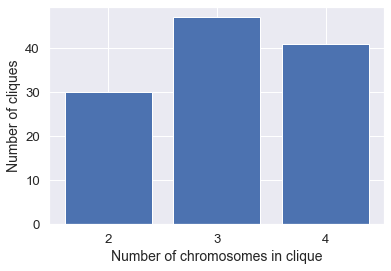

In [36]:
# For each clique, how many distinct chromosomes does it contain?
all_cliques = list(nx.find_cliques(G_thresholded))
all_cliques.sort(key = lambda x:-len(x))
n_chrom_per_clique = []
for clique in tqdm(all_cliques):
    clique_chroms = [gene2chrom[supernode.split(', ')[0]] for supernode in clique]
    clique_chroms = np.unique(clique_chroms)
    n_chrom_per_clique.append(len(clique_chroms))
x, h = np.unique(n_chrom_per_clique, return_counts=True)

sns.set(font_scale=1.2)
plt.figure()
plt.bar(x, h)
plt.xticks(np.arange(2,5,1))
plt.xlabel('Number of chromosomes in clique', size=14)
plt.ylabel('Number of cliques', size=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

# 3. Add MERFISH information

### a. Load MERFISH data

In [37]:
# Load data
merfish_data = pd.read_csv(dir_fish+'dna_merfish_data.tsv', sep='\t', header=0)

In [38]:
# Check cell size
merfish_data_reduced = merfish_data[['cell number', 'genomic coordinate', 'x(nm)', 'y(nm)', 'z(nm)']]
merfish_data_reduced = merfish_data_reduced.dropna(how='any', axis=0)

In [39]:
# Compute major axis of each nucleus
cell_ids = merfish_data_reduced['cell number'].unique()
max_dist_dict = {}
min_dist_dict = {}
for cell_id in tqdm(cell_ids):
    coords = merfish_data_reduced[merfish_data_reduced['cell number']==cell_id][['x(nm)', 'y(nm)', 'z(nm)']]
    dist = pdist(coords, metric='euclidean')
    max_dist = dist.max()
    max_dist_dict[cell_id] = max_dist
    min_dist = dist.min()
    min_dist_dict[cell_id] = min_dist

100%|██████████| 3668/3668 [00:44<00:00, 82.66it/s]


In [40]:
# Probe-probe distances in a given cell
cell_id = cell_ids[0]
coords = merfish_data_reduced[merfish_data_reduced['cell number']==cell_id]
coords = coords[['genomic coordinate', 'x(nm)', 'y(nm)', 'z(nm)']]
coords = coords.set_index('genomic coordinate')
dist_mat = squareform(pdist(coords, metric='euclidean'))
dist_df = pd.DataFrame(dist_mat, index=coords.index.values, columns=coords.index.values)
dist_df_stacked = dist_df.stack().to_frame('distance').reset_index()
dist_df_stacked.columns = ['probe1', 'probe2', 'distance']
dist_df_stacked['inter'] = dist_df_stacked.apply(
    lambda row: (row['probe1'].split(':')[0]!=row['probe2'].split(':')[0]), axis=1
)

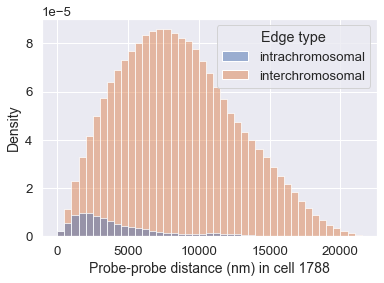

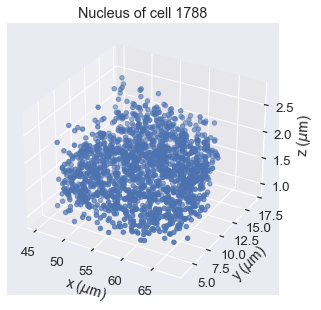

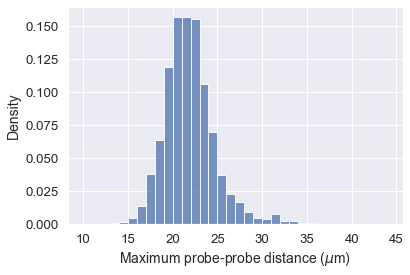

In [41]:
# Display distribution of distances within one cell
dist_df_stacked['Edge type'] = dist_df_stacked['inter'].apply(
    lambda b: 'interchromosomal' if b else 'intrachromosomal'
)
sns.set(font_scale=1.2)
plt.figure()
sns.histplot(data=dist_df_stacked, x='distance', hue='Edge type', stat='density',
             alpha=0.5, bins=np.arange(0, 22000, 500))
plt.xlabel(f'Probe-probe distance (nm) in cell {cell_id}', fontsize=14)
plt.ylabel('Density', fontsize=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

# Plot cell
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(coords['x(nm)'].values/1000, coords['y(nm)'].values/1000, coords['z(nm)'].values/1000)
ax.set_xlabel('x ($\mu$m)', fontsize=14)
ax.set_ylabel('y ($\mu$m)', fontsize=14)
ax.set_zlabel('z ($\mu$m)', fontsize=14)
plt.title(f'Nucleus of cell {cell_id}')
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

# Display distribution of maximum distance
sns.set(font_scale=1.2)
plt.figure()
sns.histplot(np.array(list(max_dist_dict.values()))/1000, stat='density', bins=np.arange(10, 45, 1))
plt.xlabel('Maximum probe-probe distance ($\mu$m)', fontsize=14)
plt.ylabel('Density', fontsize=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

In [42]:
# Build dictionary from Ensembl gene name to HGNC
enst2hgnc_df = pd.read_csv(dir_genome+'ensemblGene2Name', sep='\t', header=0)
enst2hgnc_df.columns = ['ENST', 'HGNC']
enst2hgnc_df = enst2hgnc_df.set_index('ENST')
ensg2enst_df = pd.read_csv(dir_genome+'ensemblGene2Transcript2Protein', sep='\t', header=0)
ensg2enst_df.columns = ['ENSG', 'ENST', 'ENSP']
ensg2enst_df = ensg2enst_df[['ENSG', 'ENST']]
ensg2enst_df = ensg2enst_df.set_index('ENST')
ensg2hgnc_df = ensg2enst_df.join(enst2hgnc_df, how='outer').reset_index()
ensg2hgnc_df = ensg2hgnc_df[['ENSG', 'HGNC']].drop_duplicates(['ENSG', 'HGNC'])
ensg2hgnc_df['HGNC'] = ensg2hgnc_df['HGNC'].str.upper()
ensg2hgnc_df = ensg2hgnc_df.reset_index()[['ENSG', 'HGNC']]
ensg2hgnc = {ensg2hgnc_df.loc[i,'ENSG']: ensg2hgnc_df.loc[i,'HGNC'] for i in range(len(ensg2hgnc_df))}

In [43]:
# Add gene information to MERFISH data
merfish_data['gene names'] = merfish_data['gene names'].astype(str)
merfish_data['gene names'] = merfish_data['gene names'].apply(lambda x: x.split(',') if x!='nan' else [])
merfish_data['gene_hgnc'] = merfish_data['gene names'].apply(lambda x: [ensg2hgnc[g] if (g in ensg2hgnc.keys()) 
                                                                    else 'unknown' for g in x] if len(x)>0 else [])
merfish_data['n_genes'] = merfish_data['gene_hgnc'].apply(lambda x: len(x))

merfish_data['transciption'] = merfish_data['transciption'].astype(str)
merfish_data['transciption'] = merfish_data['transciption'].apply(lambda x: x.split(',') if x!='nan' else [])

merfish_data['chrom'] = merfish_data['genomic coordinate'].str.split(':', expand=True)[0]
merfish_data['loc'] = merfish_data['genomic coordinate'].str.split(':', expand=True)[1]
merfish_data['start'] = merfish_data['loc'].str.split('-', expand=True)[0].astype(int)
merfish_data['end'] = merfish_data['loc'].str.split('-', expand=True)[1].astype(int)
merfish_data['length (kb)'] = (merfish_data['end']-merfish_data['start'])/1000

In [44]:
# Reduce data (drop NAs, chrX and gene-less loci)
subset = ['z(nm)', 'x(nm)', 'y(nm)', 'genomic coordinate', 'cell number', 'experiment number']
merfish_data = merfish_data.dropna(how='any', subset=subset)
merfish_data = merfish_data[merfish_data['chrom']!='chrX']
merfish_data = merfish_data[['cell number',
                             'chrom',
                             'homolog number',
                             'genomic coordinate',
                             'length (kb)',
                             'gene_hgnc',
                             'transciption',
                             'x(nm)', 'y(nm)', 'z(nm)']]
merfish_data.columns = [ 'cell_ID',
                         'chrom',
                         'homolog',
                         'probe_locus',
                         'probe_length(kb)',
                         'gene_ID',
                         'transcription',
                         'x(nm)', 'y(nm)', 'z(nm)']

In [45]:
# Print basic statistics
print(f'Total number of cells = {len(np.unique(merfish_data["cell_ID"].values))}')
print(f'Total number of probe loci = {len(np.unique(merfish_data["probe_locus"].values))}')
print(f'Unique probe loci lengths: {np.unique(merfish_data["probe_length(kb)"].values, return_counts=True)}')

Total number of cells = 3668
Total number of probe loci = 990
Unique probe loci lengths: (array([100.]), array([5797522]))


### b. Identify adhesome MERFISH loci

In [46]:
# Select active adhesome genes and their active TFs
selected_genes = np.concatenate([active_adhesome_genes, active_lung_adhesome_tf_genes])
print(f'Number of selected genes = {len(selected_genes)}')

Number of selected genes = 228


In [47]:
# Location of genes in hg38
df_loc = pd.read_csv(dir_genome+'chrom_hg38.loc', sep='\t', header=0)
df_loc = df_loc[df_loc['#chrom'].isin(['chr'+str(i) for i in range(1,23)])]
df_loc = df_loc[['#chrom', 'chromStart', 'chromEnd', 'geneName']]
df_loc.columns = ['chrom', 'start', 'end', 'geneName']
df_loc = df_loc.sort_values(['chrom','start','end'])
df_loc = df_loc.groupby(['chrom','geneName']).agg({'start':'min', 'end':'max'})
df_loc = df_loc.reset_index().sort_values(['chrom','start','end'])
df_loc_adhesome = df_loc[df_loc['geneName'].isin(selected_genes)]

In [48]:
# Identify MERFISH probes present within 500kb of available MERFISH probes
resol_merfish = 500000

In [49]:
# Construct a bed object for adhesome genes
df_adhesome_pos = df_loc_adhesome[['chrom','start','end', 'geneName']]
bed_adhesome = pybedtools.BedTool.from_dataframe(df_adhesome_pos).sort()
bed_adhesome_df = bed_adhesome.to_dataframe()

In [50]:
# Construct a bed object for MERFISH probes
df_merfish_pos = merfish_data.loc[:,'probe_locus'].to_frame().drop_duplicates()
df_merfish_pos['chrom'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[0]
df_merfish_pos['extent'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[1]
df_merfish_pos['start'] = df_merfish_pos['extent'].str.split('-', expand=True)[0].astype(int)
df_merfish_pos['end'] = df_merfish_pos['extent'].str.split('-', expand=True)[1].astype(int)
df_merfish_pos = df_merfish_pos[['chrom', 'start', 'end', 'probe_locus']]
df_merfish_pos['start'] = (df_merfish_pos['start']-resol_merfish).clip(lower=0)
df_merfish_pos['end'] = (df_merfish_pos['end']+resol_merfish)
bed_merfish = pybedtools.BedTool.from_dataframe(df_merfish_pos).sort()
bed_merfish_df = bed_merfish.to_dataframe()

In [51]:
# Get counts for this feature in the segmented genome
out = pybedtools.bedtool.BedTool.map(bed_merfish, bed_adhesome, c=[4], o='distinct', f=1e-9, F=0.5)
counts = out.to_dataframe()
counts['score'] = counts['score'].str.split(',')
counts['score'] = counts['score'].apply(lambda x: x if x[0]!='.' else [])
counts['n_adhesome_genes'] = counts['score'].apply(lambda x: len(x))
merfishloc2gene = {counts.loc[i,'name']: counts.loc[i,'score'] for i in range(len(counts))}

In [52]:
# Create gene2merfishloc mapping
gene2merfishloc = defaultdict(list)
for k, v in merfishloc2gene.items():
    if len(v)>0:
        for g in v:
            gene2merfishloc[g].append(k)
gene2merfishloc = dict(gene2merfishloc)

In [53]:
# Table of adhesome MERFISH probes
adhesome_probes_df = counts[counts['n_adhesome_genes']>0]
adhesome_MERFISH_genes = sorted(itertools.chain.from_iterable(adhesome_probes_df['score']))
adhesome_MERFISH_probes = adhesome_probes_df["name"].values
print(f'Number of adhesome MERFISH probes = {len(adhesome_MERFISH_probes)}')
print(f'Number of adhesome genes covered by MERFISH probes = {len(adhesome_MERFISH_genes)}')
print(f'Adhesome genes covered by MERFISH probes = {adhesome_MERFISH_genes}')

Number of adhesome MERFISH probes = 82
Number of adhesome genes covered by MERFISH probes = 95
Adhesome genes covered by MERFISH probes = ['ABI1', 'ACTB', 'ACTN1', 'ADAM12', 'AKT1', 'ARF1', 'ARHGAP32', 'ARHGEF12', 'ARHGEF2', 'ARHGEF7', 'ASAP2', 'ASAP3', 'BCAR1', 'BDP1', 'BRF1', 'CASP8', 'CASS4', 'CAV1', 'CD47', 'CEBPB', 'CFL1', 'CRKL', 'CSRP1', 'CTCF', 'DNM2', 'EP300', 'EZR', 'FHL2', 'GIT1', 'GRB2', 'GRB7', 'INPPL1', 'INSR', 'ITGA3', 'ITGA5', 'ITGB1', 'ITGB1BP1', 'ITGB2', 'ITGB3', 'ITGB3BP', 'KEAP1', 'LDB3', 'LPP', 'LRP1', 'MACF1', 'MAPK1', 'MAPK8', 'MARCKS', 'MAZ', 'MYH9', 'NEXN', 'NF2', 'NRP1', 'OSTF1', 'PARVA', 'PARVB', 'PDE4D', 'PFN1', 'PIAS4', 'PIP5K1C', 'PLAUR', 'PLEC', 'POLR2A', 'PPM1F', 'PRKACA', 'PTK2', 'PTK2B', 'PTPN1', 'PTPN12', 'PTPRO', 'RAC1', 'RAD21', 'RAPGEF1', 'RASA1', 'RAVER1', 'RB1', 'RBL1', 'RBL2', 'RNF185', 'SHARPIN', 'SIRPA', 'SLC16A3', 'SLC3A2', 'SLC9A1', 'SORBS2', 'SOS1', 'STARD13', 'STAT3', 'SUMO2', 'SVIL', 'TESK1', 'TIAM1', 'TLN1', 'TP53', 'VASP']


### c. Create adhesome MERFISH heatmap

In [54]:
# Select MERFISH data corresponding to active adhesome genes
selected_merfish_data = merfish_data.copy()
selected_merfish_data = selected_merfish_data.loc[
    selected_merfish_data['probe_locus'].isin(adhesome_MERFISH_probes), :
]

In [55]:
# A few statistics
all_merfish_loci = np.unique(selected_merfish_data["probe_locus"])
all_merfish_cells = np.unique(selected_merfish_data["cell_ID"])
print(f'Number of unique loci = {len(all_merfish_loci)}')
print(f'Number of unique cells = {len(all_merfish_cells)}')

Number of unique loci = 82
Number of unique cells = 3668


In [56]:
# Build a dictionary where for each cell, we report a probe by probe distance matrix between adhesome genes
cell2distmat = {}
n_duplicates = []
for cell in tqdm(all_merfish_cells):
    
    # FIRST SELECT CELL DATA
    cell_data = selected_merfish_data.loc[selected_merfish_data['cell_ID']==cell,
                                          ['x(nm)','y(nm)','z(nm)','probe_locus', 'homolog']]
    n_duplicates = n_duplicates+cell_data.groupby('probe_locus').size().tolist()
    cell_data['probe_locus_homolog'] = cell_data.apply(
        lambda row: row['probe_locus']+'_'+str(row['homolog']), axis=1
    )
    cell_data = cell_data[['x(nm)','y(nm)','z(nm)','probe_locus_homolog']]
    cell_data = cell_data.set_index('probe_locus_homolog')
    
    # SECOND COMPUTE DISTANCE MATRIX AND ONLY KEEP MINIMUM DISTANCE BETWEEN HOMOLOGS
    dist_mat = squareform(pdist(cell_data, metric='euclidean'))
    dist_df = pd.DataFrame(dist_mat, columns = cell_data.index.values, index = cell_data.index.values)
    dist_df = dist_df/max_dist_dict[cell]
    
    # Define new index
    old_index = dist_df.index.values
    new_index = [probe.split('_')[0] for probe in old_index]
    dist_df.index = new_index
    dist_df.columns = new_index
    # Groupby new index
    grouper = dist_df.index
    dist_df = dist_df.groupby(grouper, sort=False, axis=0).min()
    dist_df = dist_df.groupby(grouper, sort=False, axis=1).min()
    
    # LAST SAVE RESULTING DISTANCE MATRIX
    cell2distmat[cell] = dist_df
        
# Checking that we have at most 2 measurements for each probe, corresponding to the 2 chromosome homologs
print(np.unique(n_duplicates, return_counts=True))

100%|██████████| 3668/3668 [00:26<00:00, 137.11it/s]

(array([1, 2]), array([ 54218, 237376]))


In [57]:
# Combine information across all cells into one dataframe to get the mean
distances_df = pd.DataFrame(0, columns=all_merfish_loci, index=all_merfish_loci)
squared_distances_df = pd.DataFrame(0, columns=all_merfish_loci, index=all_merfish_loci)
n_samples_df = pd.DataFrame(0, columns=all_merfish_loci, index=all_merfish_loci)
for cell in tqdm(all_merfish_cells):
    cell_dist_mat = cell2distmat[cell]
    cell_idx = cell_dist_mat.index.values
    distances_df.loc[cell_idx, cell_idx] += cell_dist_mat
    squared_distances_df.loc[cell_idx, cell_idx] += cell_dist_mat**2
    n_samples_df.loc[cell_idx, cell_idx] += 1 
n_samples_df = n_samples_df.replace(0, np.nan)

100%|██████████| 3668/3668 [00:22<00:00, 159.75it/s]


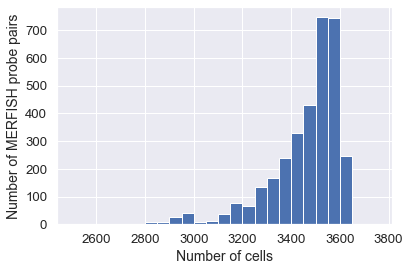

In [58]:
# Plot distribution of number of cells per probe-probe distance measurement
sns.set(font_scale=1.2)
plt.figure()
plt.hist(n_samples_df.values[np.triu_indices(len(n_samples_df), 1)], bins=np.arange(2500, 3800, 50))
plt.xlabel('Number of cells', size=14)
plt.ylabel('Number of MERFISH probe pairs', size=14)
# plt.title('Number of cells per probe-probe distance measurement', size=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

Maximum average distance = 0.2670262834826436
Maximum standard deviation = 0.15890308708873388


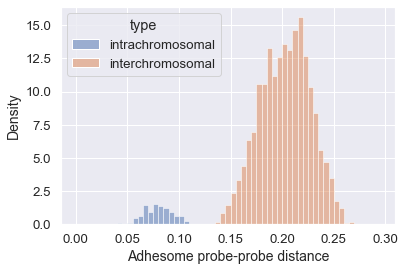

In [59]:
# Average and std distance dataframes
avg_dist_df = distances_df/n_samples_df
std_dist_df = np.sqrt(squared_distances_df/n_samples_df-avg_dist_df**2)

# Order average and std distance dataframes
ordered_index_df = std_dist_df.index.to_frame()
ordered_index_df.columns = ['probe_name']
ordered_index_df['chrom'] = ordered_index_df['probe_name'].str.split(':', expand=True)[0]
ordered_index_df['chrom'] = ordered_index_df['chrom'].str.split('chr', expand=True)[1].astype(int)
ordered_index_df['start'] = ordered_index_df['probe_name'].str.split(':', expand=True)[1]
ordered_index_df['start'] = ordered_index_df['start'].str.split('-', expand=True)[0].astype(int)
ordered_index_df = ordered_index_df.sort_values(['chrom', 'start'])
ordered_index = ordered_index_df.index.values
avg_dist_df = avg_dist_df.loc[ordered_index, ordered_index]
std_dist_df = std_dist_df.loc[ordered_index, ordered_index]
print(f'Maximum average distance = {avg_dist_df.max().max()}')
print(f'Maximum standard deviation = {std_dist_df.max().max()}')
avg_scaled_dist_df = avg_dist_df/avg_dist_df.max().max()
avg_scaled_prox_df = 1-avg_scaled_dist_df

# Add metadata to every MERFISH edge
avg_dist_df_stacked = avg_dist_df.stack().to_frame('distance').reset_index()
avg_dist_df_stacked['chr1'] = avg_dist_df_stacked['level_0'].str.split(':', expand=True)[0]
avg_dist_df_stacked['chr2'] = avg_dist_df_stacked['level_1'].str.split(':', expand=True)[0]
avg_dist_df_stacked.columns = ['probe1', 'probe2', 'distance', 'chr1', 'chr2']
avg_dist_df_stacked = avg_dist_df_stacked[['probe1', 'probe2', 'chr1', 'chr2', 'distance']]
avg_dist_df_stacked['type'] = avg_dist_df_stacked.apply(
    lambda row: 'intrachromosomal' if (row['chr1']==row['chr2']) else 'interchromosomal', axis=1
)
# Drop self edges
avg_dist_df_stacked = avg_dist_df_stacked[avg_dist_df_stacked['probe1']!=avg_dist_df_stacked['probe2']]

# Plot distribution of probe-probe distance
sns.set(font_scale=1.2)
plt.figure()
ax = sns.histplot(data=avg_dist_df_stacked, x='distance', hue='type', stat='density',
                  bins=np.arange(0, 0.3, 0.005))
sns.move_legend(ax, "upper left")
plt.xlabel('Adhesome probe-probe distance', size=14)
plt.ylabel('Density', size=14)
# plt.title('Distribution of adhesome probe-probe cell-normalized distance', size=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

# # Plot heatmap of standard deviations
# sns.set(font_scale=1.2)
# plt.figure(figsize=(11,10))
# sns.heatmap(std_dist_df, cmap='Reds', xticklabels=False, yticklabels=False, vmin=0, vmax=1)
# plt.xlabel('adhesome MERFISH probes', size=14)
# plt.ylabel('adhesome MERFISH probes', size=14)
# plt.title('Standard deviation of pairwise probe cell-normalized distance', size=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
# plt.show()

### d. Compute MERFISH strength between supernodes in HiC+reg graph

In [60]:
# Dictionary mapping supernodes to MERFISH loci
supernode2merfishloc = {}
for supernode in G_thresholded.nodes:
    supernode_genes = supernode.split(', ')
    supernode_merfishloc = [gene2merfishloc[g] for g in supernode_genes if (g in gene2merfishloc.keys())]
    supernode_merfishloc = sorted(itertools.chain.from_iterable(supernode_merfishloc))
    supernode_merfishloc = np.unique(supernode_merfishloc)
    supernode2merfishloc[supernode] = supernode_merfishloc

In [61]:
# Create distance matrix between supernodes
supernodes_list = sorted(G_thresholded.nodes)
supernodes_dist_df = pd.DataFrame(0, index=supernodes_list, columns=supernodes_list)
for supernode1, supernode2 in itertools.combinations(supernodes_list, 2):
    merfishloc_1 = supernode2merfishloc[supernode1]
    merfishloc_2 = supernode2merfishloc[supernode2]
    if ((len(merfishloc_1)==0) | len(merfishloc_2)==0):
        supernodes_dist_df.loc[supernode1, supernode2] = np.nan
    else:
        supernodes_dist_df.loc[supernode1, supernode2] = avg_dist_df.loc[merfishloc_1, merfishloc_2].mean().mean()

supernodes_dist_df = supernodes_dist_df+supernodes_dist_df.T
supernodes_dist_df = supernodes_dist_df

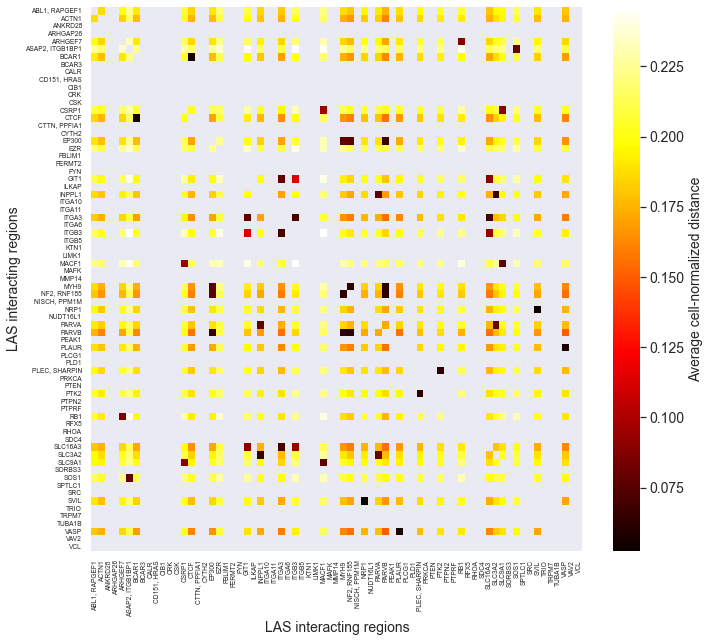

In [62]:
# Display distance matrix between supernodes
supernodes_dist_df_display = supernodes_dist_df.copy()
np.fill_diagonal(supernodes_dist_df_display.values, np.nan)

sns.set(font_scale=0.6)
plt.figure(figsize=(11,10))
ax = sns.heatmap(supernodes_dist_df_display, cmap='hot', cbar_kws={'label': 'Average cell-normalized distance'})
ax.figure.axes[-1].yaxis.label.set_size(14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

plt.xlabel('LAS interacting regions', fontsize = 14)
plt.ylabel('LAS interacting regions', fontsize = 14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

### e. Compare MERFISH edges and HiC+reg edges

In [63]:
# List of supernodes that have associated MERFISH loci
selected_supernodes = [k for k,v in supernode2merfishloc.items() if (len(v)>0)]

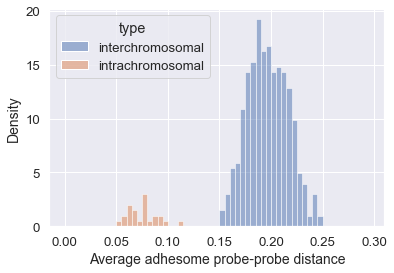

In [64]:
# Restrict MERFISH dist matrix to these supernodes
restricted_merfish_dist = supernodes_dist_df.copy()
restricted_merfish_dist = restricted_merfish_dist.loc[selected_supernodes, selected_supernodes]

# InterX and intraX MERFISH distances
restricted_merfish_dist_stacked = restricted_merfish_dist.stack().to_frame('distance').reset_index()
restricted_merfish_dist_stacked.columns = ['supernode1', 'supernode2', 'distance']
restricted_merfish_dist_stacked['chrom1'] = restricted_merfish_dist_stacked['supernode1'].apply(
    lambda supernode: gene2chrom[supernode.split(', ')[0]]
)
restricted_merfish_dist_stacked['chrom2'] = restricted_merfish_dist_stacked['supernode2'].apply(
    lambda supernode: gene2chrom[supernode.split(', ')[0]]
)
restricted_merfish_dist_stacked['type'] = restricted_merfish_dist_stacked.apply(
    lambda row: 'intrachromosomal' if (row['chrom1']==row['chrom2']) else 'interchromosomal', axis=1
)
# Drop self edges
restricted_merfish_dist_stacked = restricted_merfish_dist_stacked[
    restricted_merfish_dist_stacked['supernode1']!=restricted_merfish_dist_stacked['supernode2']
]
# Only select interX edges
merfish_dist_inter = restricted_merfish_dist_stacked[restricted_merfish_dist_stacked['type']=='interchromosomal']

# Plot distribution of distances
t_merfish = np.quantile(merfish_dist_inter['distance'].values, 0.25)
sns.set(font_scale=1.2)
plt.figure()
sns.histplot(data=restricted_merfish_dist_stacked, x='distance', stat='density', 
             hue='type',bins=np.arange(0, 0.3, 0.005))
# plt.vlines(x=t_merfish, ymin=0, ymax=20, color='red', linestyle='dashed', alpha=0.5)
plt.xlabel('Average adhesome probe-probe distance', fontsize=14)
plt.ylabel('Density', fontsize=14)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

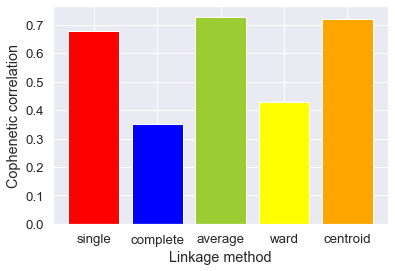

In [65]:
# Plot heatmap of MERFISH distance between supernodes

# Create adjacency matrix with NaNs for intraX distances
restricted_merfish_dist_stacked_inter = restricted_merfish_dist_stacked.copy()
restricted_merfish_dist_stacked_inter['distance'] = restricted_merfish_dist_stacked_inter.apply(
    lambda row: row['distance'] if (row['type']=='interchromosomal') else np.nan, axis=1
)
restricted_merfish_dist_stacked_inter = restricted_merfish_dist_stacked_inter[
    ['supernode1', 'supernode2', 'distance']
]
restricted_merfish_dist_stacked_inter = restricted_merfish_dist_stacked_inter.set_index(
    ['supernode1', 'supernode2']
)
restricted_merfish_dist_inter = restricted_merfish_dist_stacked_inter.unstack()
restricted_merfish_dist_inter = restricted_merfish_dist_inter.droplevel(None, axis=1)

# To be able to cluster, we will fill NaN values with the maximum distance and scale the matrix
MM = restricted_merfish_dist_inter.max().max()
mm = restricted_merfish_dist_inter.min().min()
restricted_merfish_dist_inter = (restricted_merfish_dist_inter-mm)/(MM-mm)
restricted_merfish_dist_inter = restricted_merfish_dist_inter.fillna(1)
np.fill_diagonal(restricted_merfish_dist_inter.values, 0)

# Obtain row and column linkage
y = sp.distance.squareform(restricted_merfish_dist_inter.values)

# Check which linkage to use using cophenetic correlation
cophenet_single = cophenet(linkage(y, method='single'), y)[0]
cophenet_complete = cophenet(linkage(y, method='complete'), y)[0]
cophenet_average = cophenet(linkage(y, method='average'), y)[0]
cophenet_ward = cophenet(linkage(y, method='ward'), y)[0]
cophenet_centroid = cophenet(linkage(y, method='centroid'), y)[0]
sns.set(font_scale=1.2)
plt.figure()
plt.bar(x=['single', 'complete', 'average', 'ward', 'centroid'],
        height = [cophenet_single, cophenet_complete, cophenet_average, cophenet_ward, cophenet_centroid],
        color = ['red', 'blue', 'yellowgreen', 'yellow', 'orange'])
plt.xlabel('Linkage method')
plt.ylabel('Cophenetic correlation')
plt.show()

AttributeError: 'ClusterGrid' object has no attribute 'collections'

<Figure size 792x720 with 0 Axes>

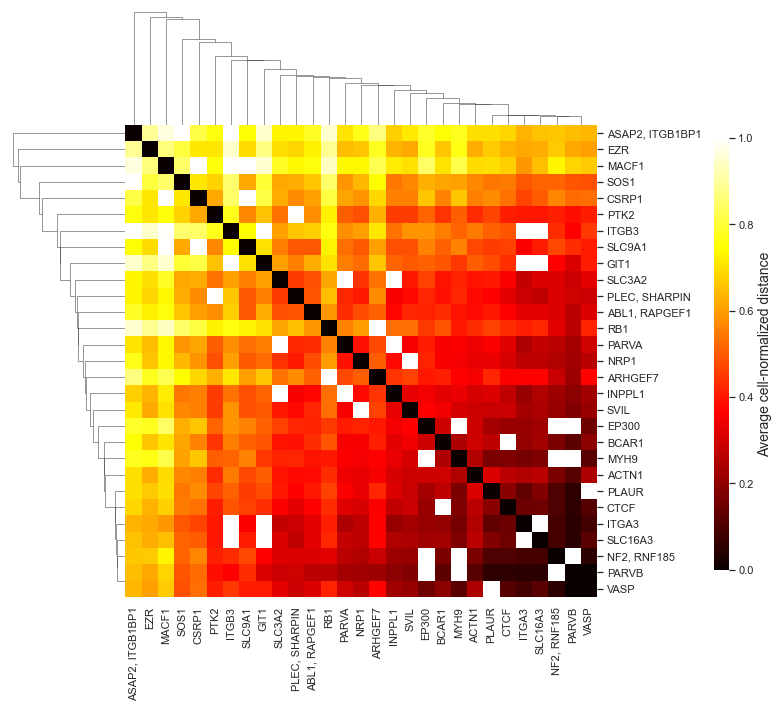

In [66]:
# Plot clustermap
linkage_y = linkage(y, method='single')
order = np.array(selected_supernodes)[np.array(dendrogram(linkage_y, no_plot=True)['ivl']).astype(int)]
restricted_merfish_dist_inter.index.name = '' # 'LAS interacting regions'
restricted_merfish_dist_inter.columns.name = '' # 'LAS interacting regions'

sns.set(font_scale=1)
plt.figure(figsize=(11,10))
ax = sns.clustermap(data=restricted_merfish_dist_inter, 
               row_cluster=True, col_cluster=True,
               row_linkage=linkage_y, col_linkage=linkage_y,
               cmap='hot', cbar_pos=(1,0.2,0.02,0.6), 
               cbar_kws={'label': 'Average cell-normalized distance'})
ax.figure.axes[-1].yaxis.label.set_size(14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

plt.xlabel('')
plt.ylabel('')
# plt.title('Scaled MERFISH cell-normalized distance between adhesome groups', size=14)
plt.show()

In [83]:
# Manually redefine order
order = ['ASAP2, ITGB1BP1',
         'EZR',
         'MACF1',
         'SOS1',
         'CSRP1',
    
         'ITGB3',
         'PTK2',
         'SLC9A1',
         'GIT1',
         'RB1',
         'ARHGEF7',
         'SLC3A2',
         'PLEC, SHARPIN',
         'ABL1, RAPGEF1',
         'PARVA',
         'NRP1',
         'INPPL1',
         'SVIL',
         'EP300',
         'BCAR1',
         'MYH9',
         'ACTN1',
         'PLAUR',
         'CTCF',
         'ITGA3',
         'SLC16A3',
         'NF2, RNF185',
         'PARVB',
         'VASP']

In [84]:
# Compare Hi-C, regulatory correlation and MERFISH heatmaps

# Process MERFISH edges
merfish_stacked = restricted_merfish_dist_stacked_inter.reset_index().copy()
merfish_stacked['edge_id'] = merfish_stacked.apply(
    lambda row: '_'.join(sorted([row['supernode1'], row['supernode2']])), axis=1
)
# merfish_stacked = merfish_stacked.drop_duplicates(subset=['edge_id'])
merfish_stacked = merfish_stacked.set_index('edge_id')

# Process Hi-C and regulatory edges
las_stacked = edge_data[['source', 'target', 'avg', 'reg_corr']]
las_stacked.columns = ['supernode1', 'supernode2', 'hic', 'reg_corr']
las_stacked['edge_id'] = las_stacked.apply(
    lambda row: '_'.join(sorted([row['supernode1'], row['supernode2']])), axis=1
)
las_stacked = las_stacked.set_index('edge_id')
las_stacked = las_stacked[['hic', 'reg_corr']]

# Combine edge metadata
combined_edge_stacked = merfish_stacked.join(las_stacked, how='left')
# combined_edge_stacked = combined_edge_stacked.dropna(axis=0, how='any')
# order = np.delete(order, np.where(order=='LPP')[0])

# Heatmap of MERFISH
merfish_adj = combined_edge_stacked[['supernode1', 'supernode2', 'distance']]
merfish_adj = merfish_adj.set_index(['supernode1', 'supernode2'])
merfish_adj = merfish_adj.unstack()
merfish_adj = merfish_adj.droplevel(None, axis=1)
merfish_adj = merfish_adj.loc[order, order]
mm = merfish_adj.min().min()
MM = merfish_adj.max().max()
merfish_adj = 1-(merfish_adj-mm)/(MM-mm)

# Heatmap of HiC
hic_adj = combined_edge_stacked[['supernode1', 'supernode2', 'hic']]
hic_adj = hic_adj.set_index(['supernode1', 'supernode2'])
hic_adj = hic_adj.unstack()
hic_adj = hic_adj.droplevel(None, axis=1)
hic_adj = hic_adj.loc[order, order]
mm = hic_adj.min().min()
MM = hic_adj.max().max()
hic_adj = (hic_adj-mm)/(MM-mm)

# Heatmap of reg
reg_adj = combined_edge_stacked[['supernode1', 'supernode2', 'reg_corr']]
reg_adj = reg_adj.set_index(['supernode1', 'supernode2'])
reg_adj = reg_adj.unstack()
reg_adj = reg_adj.droplevel(None, axis=1)
reg_adj = reg_adj.loc[order, order]

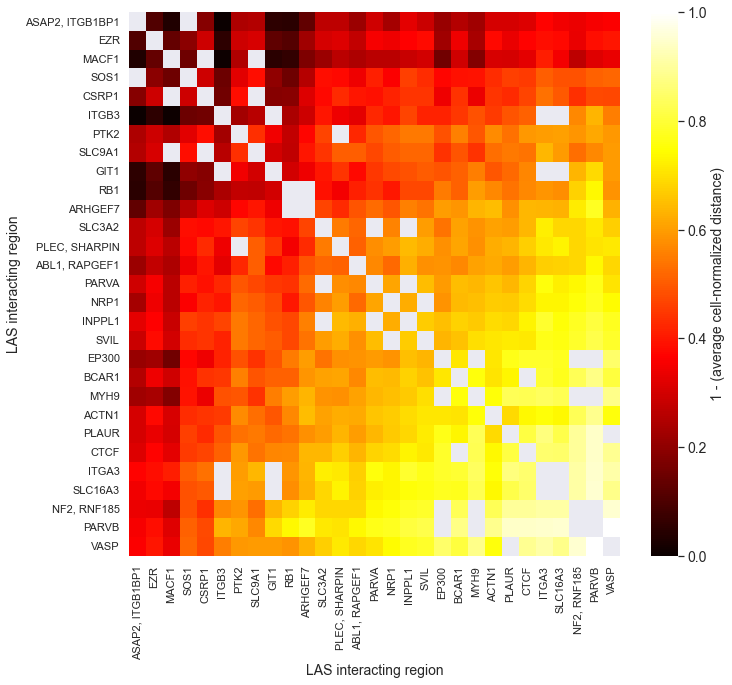

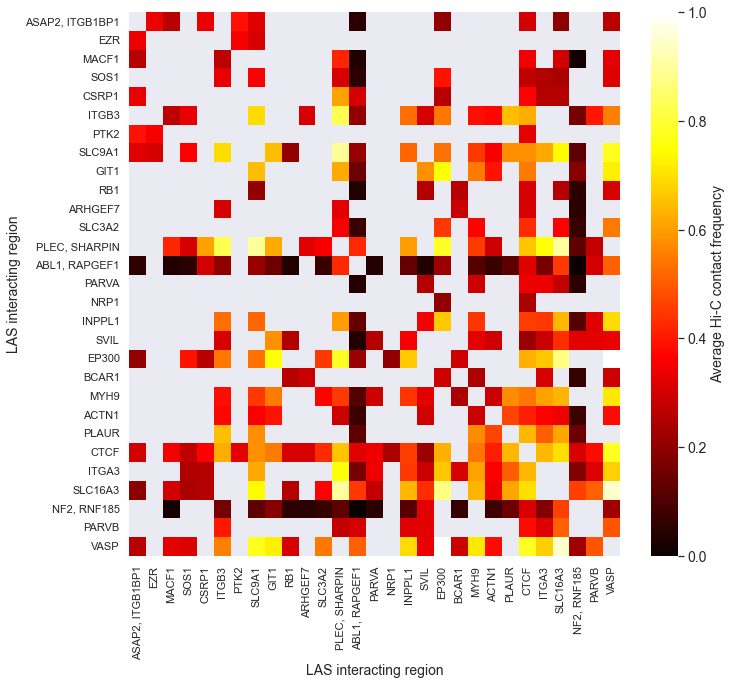

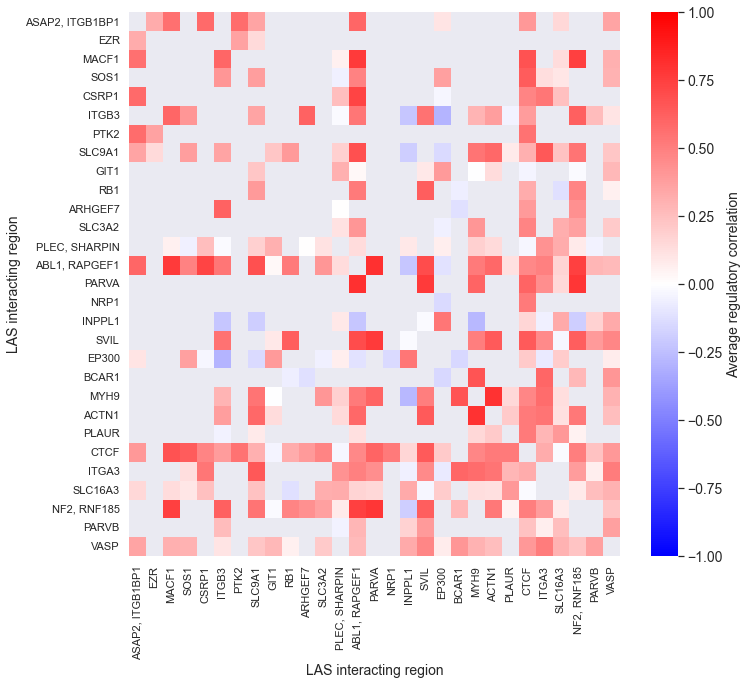

In [85]:
# Display heatmaps

plt.figure(figsize=(11,10))
ax = sns.heatmap(merfish_adj, cmap='hot', vmin=0, vmax=1, 
                 cbar_kws={'label': '1 - (average cell-normalized distance)'})
ax.figure.axes[-1].yaxis.label.set_size(14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.xlabel('LAS interacting region', fontsize=14)
plt.ylabel('LAS interacting region', fontsize=14)
# plt.title('MERFISH proximity', fontsize=14)
plt.show()

plt.figure(figsize=(11,10))
ax = sns.heatmap(hic_adj, cmap='hot', vmin=0, vmax=1, 
                 cbar_kws={'label': 'Average Hi-C contact frequency'})
ax.figure.axes[-1].yaxis.label.set_size(14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.xlabel('LAS interacting region', fontsize=14)
plt.ylabel('LAS interacting region', fontsize=14)
# plt.title('Hi-C', fontsize=14)
plt.show()

# Regulatory correlation
plt.figure(figsize=(11,10))
ax = sns.heatmap(reg_adj, cmap='bwr', vmin=-1, vmax=1, 
                 cbar_kws={'label': 'Average regulatory correlation'})
ax.figure.axes[-1].yaxis.label.set_size(14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.xlabel('LAS interacting region', fontsize=14)
plt.ylabel('LAS interacting region', fontsize=14)
# plt.title('Regulatory correlation', fontsize=14)
plt.show()

In [13]:
# Fill in HiC heatmap with extra information

# Adhesome loci per chromosome
active_adhesome_loci = sorted(itertools.chain.from_iterable([gene2locus[g] for g in active_adhesome_genes]))
active_tf_loci = sorted(itertools.chain.from_iterable([gene2locus[g] for g in active_lung_adhesome_tf_genes]))
selected_loci = np.unique(active_adhesome_loci+active_tf_loci)
selected_loci_dict = defaultdict(list)
for locus in selected_loci:
    chrom = int(locus.split('_')[1])
    selected_loci_dict[chrom].append(int(locus.split('_')[3])//resol)

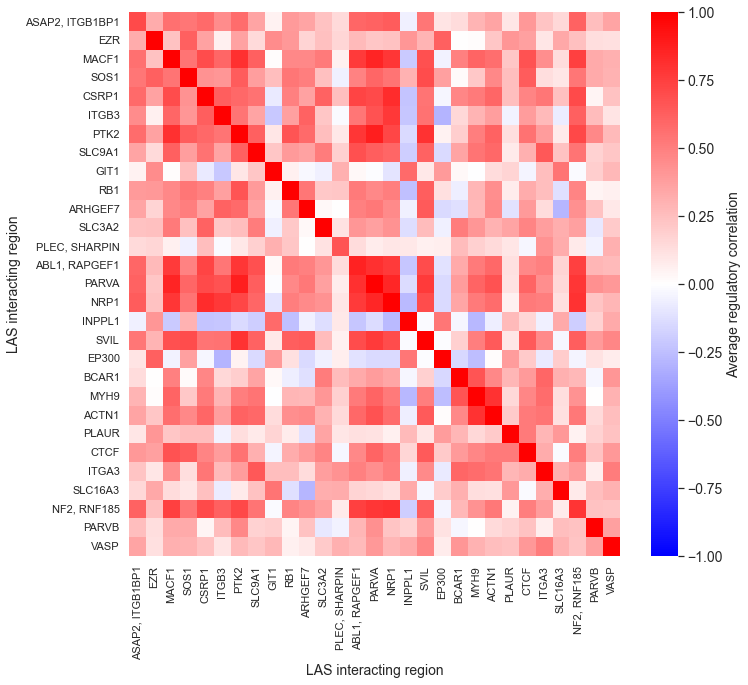

In [111]:
# Fill in correlation heatmap with extra information
reg_adj_stacked = reg_adj.stack(dropna=False)
reg_adj_stacked = reg_adj_stacked.to_frame('filtered_regcorr')
reg_adj_stacked = reg_adj_stacked.reset_index()
reg_adj_stacked['source_genes'] = reg_adj_stacked['supernode1'].str.split(', ')
reg_adj_stacked['target_genes'] = reg_adj_stacked['supernode2'].str.split(', ')
reg_adj_stacked['reg_corr'] = reg_adj_stacked.apply(
    lambda row: cross_corr(row['source_genes'], row['target_genes'], R_adhesome), axis=1
)
reg_adj_stacked = reg_adj_stacked[['supernode1', 'supernode2', 'reg_corr']]
reg_adj_stacked = reg_adj_stacked.set_index(['supernode1', 'supernode2'])
reg_adj_unstacked = reg_adj_stacked.unstack()
reg_adj_unstacked = reg_adj_unstacked.droplevel(None, axis=1)
reg_adj_unstacked = reg_adj_unstacked.loc[order, order]

plt.figure(figsize=(11,10))
ax = sns.heatmap(reg_adj_unstacked, cmap='bwr', vmin=-1, vmax=1, 
                 cbar_kws={'label': 'Average regulatory correlation'})
ax.figure.axes[-1].yaxis.label.set_size(14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.xlabel('LAS interacting region', fontsize=14)
plt.ylabel('LAS interacting region', fontsize=14)
# plt.title('Regulatory correlation', fontsize=14)
plt.show()

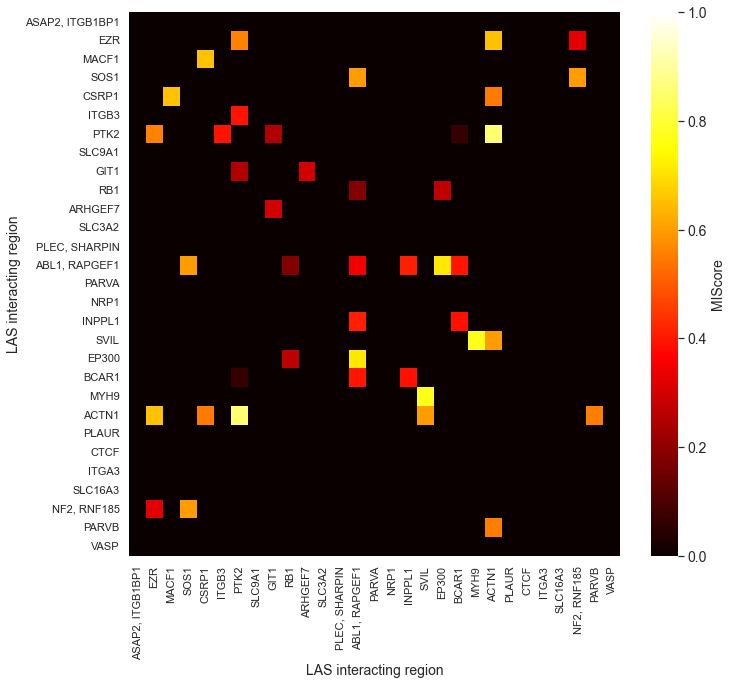

In [184]:
# Add PPI information from IREF
ppi_filename = dir_ppi+'iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt'
ppi_df = pd.read_csv(ppi_filename, sep='\t')
ppi_adj = pd.DataFrame(0, index=order, columns=order)
ppi_adj_stacked = ppi_adj.stack(dropna=False)
ppi_adj_stacked = ppi_adj_stacked.to_frame('MIScore')
ppi_adj_stacked = ppi_adj_stacked.reset_index()
ppi_adj_stacked.columns = ['supernode1', 'supernode2', 'MIScore']
ppi_adj_stacked['source_genes'] = ppi_adj_stacked['supernode1'].str.split(', ')
ppi_adj_stacked['target_genes'] = ppi_adj_stacked['supernode2'].str.split(', ')

def ppi_interaction(genes1, genes2, ppi_df):
    
    interaction_df1 = ppi_df[(ppi_df['protein1'].isin(genes1)) & (ppi_df['protein2'].isin(genes2))]
    interaction_df1 = interaction_df1.set_index(['protein1', 'protein2'])
    interaction_df1 = interaction_df1.unstack()
    interaction_df1 = interaction_df1.fillna(0)
    out1 = interaction_df1.max().max() if ~np.isnan(interaction_df1.max().max()) else 0
    
    interaction_df2 = ppi_df[(ppi_df['protein2'].isin(genes1)) & (ppi_df['protein1'].isin(genes2))]
    interaction_df2 = interaction_df2.set_index(['protein1', 'protein2'])
    interaction_df2 = interaction_df2.unstack()
    interaction_df2 = interaction_df2.fillna(0)
    out2 = interaction_df2.max().max() if ~np.isnan(interaction_df2.max().max()) else 0
    
    out = max(out1, out2)
    
    return(out)


ppi_adj_stacked['MIScore'] = ppi_adj_stacked.apply(
    lambda row: ppi_interaction(row['source_genes'], row['target_genes'], ppi_df), axis=1
)
ppi_adj_stacked = ppi_adj_stacked[['supernode1', 'supernode2', 'MIScore']]
ppi_adj_stacked = ppi_adj_stacked.set_index(['supernode1', 'supernode2'])
ppi_adj_unstacked = ppi_adj_stacked.unstack()
ppi_adj_unstacked = ppi_adj_unstacked.droplevel(None, axis=1)
ppi_adj_unstacked = ppi_adj_unstacked.loc[order, order]

plt.figure(figsize=(11,10))
ax = sns.heatmap(ppi_adj_unstacked, cmap='hot', vmin=0, vmax=1, 
                 cbar_kws={'label': 'MIScore'})
ax.figure.axes[-1].yaxis.label.set_size(14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.xlabel('LAS interacting region', fontsize=14)
plt.ylabel('LAS interacting region', fontsize=14)
# plt.title('iREF interactions', fontsize=14)
plt.show()

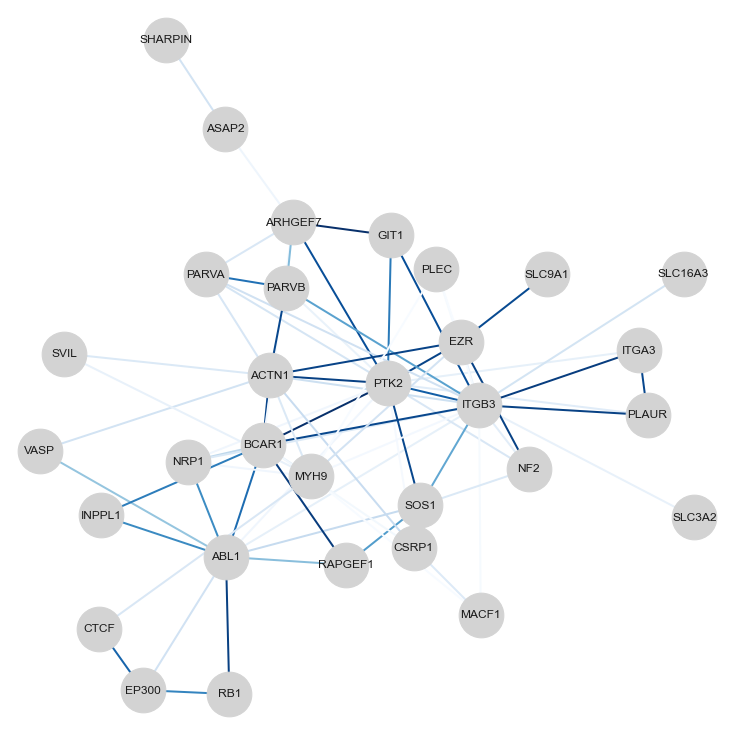

In [278]:
# Add PPI information from STRING

# 1- Save list of genes as txt for look up at 
# https://string-db.org/cgi/input?sessionId=bSN57PdA9N4N&input_page_show_search=on
string_genes = ppi_adj_unstacked.index.values
string_genes = sorted(itertools.chain.from_iterable([gg.split(', ') for gg in string_genes]))
string_genes = np.unique(string_genes)
np.savetxt('genes_for_STRING.txt', string_genes, delimiter=',', fmt='%s')

# After looking up gene interactions in STRING, load network data from the website
net_coords = pd.read_csv(dir_ppi+'STRING/'+'string_network_coordinates.tsv', sep='\t')
net_coords = net_coords[['node', 'identifier', 'x_position', 'y_position', 'annotation']]
net_edges = pd.read_csv(dir_ppi+'STRING/'+'string_interactions_short.tsv', sep='\t')
net_edges = net_edges[['node1', 'node2', 'experimentally_determined_interaction',
                       'database_annotated', 'automated_textmining', 'combined_score']]

# Define a networkx graph
STRING_G = nx.from_pandas_edgelist(net_edges, 'node1', 'node2', True, nx.Graph())
nx.set_node_attributes(STRING_G, net_coords.set_index('node').to_dict('index'))
pos = {k: [v['x_position'], v['y_position']] for k,v in STRING_G.nodes(data=True)}
widths = np.array(list(nx.get_edge_attributes(STRING_G,'combined_score').values()))
plt.figure(figsize=(10,10))
nx.draw(STRING_G, pos=pos, with_labels=True, 
        width=2, edge_color=widths, edge_cmap=plt.cm.Blues,
        node_size=2000, node_color='lightgrey')
plt.show()

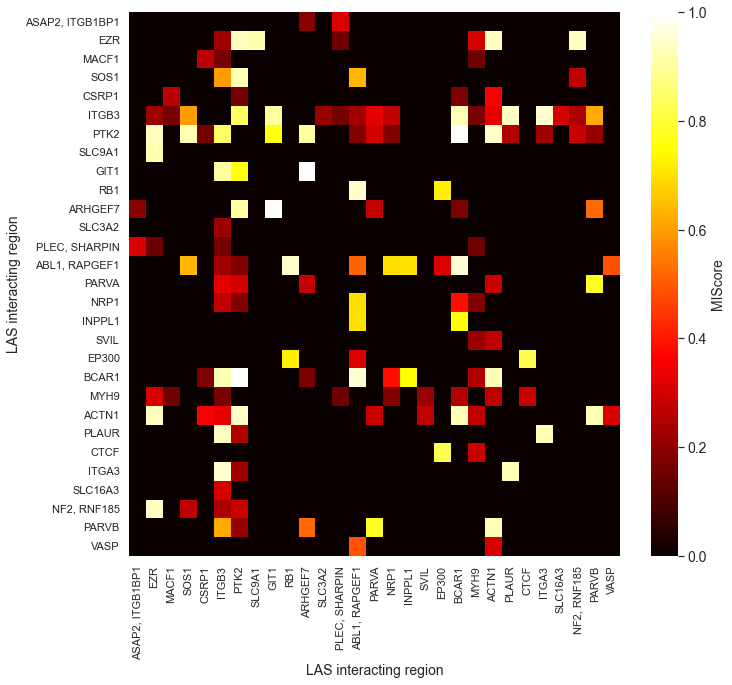

In [279]:
# Plot STRING heatmap
ppi_adj = pd.DataFrame(0, index=order, columns=order)
ppi_adj_stacked = ppi_adj.stack(dropna=False)
ppi_adj_stacked = ppi_adj_stacked.to_frame('MIScore')
ppi_adj_stacked = ppi_adj_stacked.reset_index()
ppi_adj_stacked.columns = ['supernode1', 'supernode2', 'MIScore']
ppi_adj_stacked['source_genes'] = ppi_adj_stacked['supernode1'].str.split(', ')
ppi_adj_stacked['target_genes'] = ppi_adj_stacked['supernode2'].str.split(', ')

def ppi_interaction(genes1, genes2, net_edges):
    
    interaction_df1 = net_edges[(net_edges['node1'].isin(genes1)) & (net_edges['node2'].isin(genes2))]
    interaction_df1 = interaction_df1.set_index(['node1', 'node2'])
    interaction_df1 = interaction_df1.unstack()
    interaction_df1 = interaction_df1.fillna(0)
    out1 = interaction_df1.max().max() if ~np.isnan(interaction_df1.max().max()) else 0
    
    interaction_df2 = net_edges[(net_edges['node2'].isin(genes1)) & (net_edges['node1'].isin(genes2))]
    interaction_df2 = interaction_df2.set_index(['node1', 'node2'])
    interaction_df2 = interaction_df2.unstack()
    interaction_df2 = interaction_df2.fillna(0)
    out2 = interaction_df2.max().max() if ~np.isnan(interaction_df2.max().max()) else 0
    
    out = max(out1, out2)
    
    return(out)

ppi_adj_stacked['MIScore'] = ppi_adj_stacked.apply(
    lambda row: ppi_interaction(row['source_genes'], row['target_genes'], net_edges), axis=1
)
ppi_adj_stacked = ppi_adj_stacked[['supernode1', 'supernode2', 'MIScore']]
ppi_adj_stacked = ppi_adj_stacked.set_index(['supernode1', 'supernode2'])
ppi_adj_unstacked = ppi_adj_stacked.unstack()
ppi_adj_unstacked = ppi_adj_unstacked.droplevel(None, axis=1)
ppi_adj_unstacked = ppi_adj_unstacked.loc[order, order]

plt.figure(figsize=(11,10))
ax = sns.heatmap(ppi_adj_unstacked, cmap='hot', vmin=0, vmax=1, 
                 cbar_kws={'label': 'MIScore'})
ax.figure.axes[-1].yaxis.label.set_size(14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.xlabel('LAS interacting region', fontsize=14)
plt.ylabel('LAS interacting region', fontsize=14)
# plt.title('iREF interactions', fontsize=14)
plt.show()

In [288]:
# Select subgraph of clustered adhesome interacting regions
selected_interacting_regions = order[-15:]

# 1. Only keep nodes from the selected maximal cliques
G_summary = G.copy()
G_summary = G_summary.subgraph(selected_interacting_regions)

# 2. Add MERFISH distance and physical interaction
merfish_dist_dict = {e: 1-supernodes_dist_df.loc[e[0], e[1]] for e in G_summary.edges}
nx.set_edge_attributes(G_summary, merfish_dist_dict, 'MERFISH distance')
string_interact_dict = {e: ppi_adj_unstacked.loc[e[0], e[1]] for e in G_summary.edges}
nx.set_edge_attributes(G_summary, string_interact_dict, 'STRING interaction')

# 3. Save network
oi.output_networkx_graph_as_interactive_html(G_summary, 
                                             output_dir='/home/louiscam/projects/gpcr/code/analysis_LAS/',
                                             filename='las_merfish_graph.html')

PosixPath('/home/louiscam/projects/gpcr/code/analysis_LAS/las_merfish_graph.html')

### f. Analyze maximal cliques

In [131]:
# Select maximal cliques whose supernodes have MERFISH probes
selected_supernodes_set = set(selected_supernodes)
selected_cliques = []
n_merfish_mapped = []
for clique in all_cliques:
    set_clique = set(clique)
    intersection = set.intersection(*[selected_supernodes_set, set_clique])
    if (len(intersection)>=2):
        selected_cliques.append(clique)
        n_merfish_mapped.append(len(intersection))

In [132]:
# Order cliques by average MERFISH distance
selected_cliques_merfish_strength = pd.DataFrame({
    'clique': selected_cliques,
    'number_of_nodes_in_clique': [len(c) for c in selected_cliques],
    'number_of_nodes_with_merfish_probe': n_merfish_mapped,
    'chromosomes': [[gene2chrom[n.split(', ')[0]] for n in c] for c in selected_cliques],
    'avg_merfish_distance': 0
})
for i, clique in enumerate(selected_cliques_merfish_strength['clique']):
    # Compute MERFISH strength of clique
    clique_merfish = supernodes_dist_df.loc[clique, clique]
    clique_merfish_vec = clique_merfish.values[np.triu_indices(len(clique_merfish), 1)]
    clique_merfish_vec = clique_merfish_vec[~np.isnan(clique_merfish_vec)]
    clique_merfish_dist = np.mean(clique_merfish_vec)
    selected_cliques_merfish_strength.iloc[i, 4] = clique_merfish_dist
selected_cliques_merfish_strength = selected_cliques_merfish_strength[
    selected_cliques_merfish_strength['number_of_nodes_in_clique']>2
]
selected_cliques_merfish_strength = selected_cliques_merfish_strength.sort_values(
    ['number_of_nodes_with_merfish_probe', 'avg_merfish_distance'], ascending=[False, True]
)

In [133]:
# Establish significance of cliques

# Obtain null distributions
clique_probe_sizes = selected_cliques_merfish_strength['number_of_nodes_with_merfish_probe'].unique()
n_reps = 1000
null_distributions = {s: [] for s in clique_probe_sizes}
np.random.seed(13)

for s in tqdm(clique_probe_sizes):
    for _ in range(n_reps):
        # Randomly select s nodes among supernodes that have MERFISH probes 
        rand_nodes = np.random.choice(a=selected_supernodes, size=s, replace=False)
        merfish_mat = supernodes_dist_df.loc[rand_nodes, rand_nodes].values
        merfish_vals = merfish_mat[np.triu_indices(len(merfish_mat),1)]
        avg_merfish = np.mean(merfish_vals)
        # Add avg_merfish to null distribution for that size
        null_distributions[s].append(avg_merfish)
null_distributions = {k: np.array(v) for k, v in null_distributions.items()}

# Compute p-values and sort
selected_cliques_merfish_strength['pval'] = selected_cliques_merfish_strength.apply(
    lambda row: np.mean(row['avg_merfish_distance']>=null_distributions[row['number_of_nodes_with_merfish_probe']]),
    axis=1
)
selected_cliques_merfish_strength = selected_cliques_merfish_strength.sort_values(
    ['pval', 'number_of_nodes_with_merfish_probe'], ascending=[True, False]
)

100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


In [134]:
# Load adhesome network

# Load components
components_filename = 'components.csv'
df_components = pd.read_csv(dir_adhesome+components_filename, sep = ',', header = 0)
print('Number of components: '+str(len(df_components)))
print('Number of intrinsic components: '+str(len(df_components[df_components['FA']=='Intrinsic Proteins'])))
print('Number of associated components: '+str(len(df_components[df_components['FA']=='Associated Proteins'])))
df_components.head()

# Load interactions
interactions_filename = 'interactions.csv'
df_interactions = pd.read_csv(dir_adhesome+interactions_filename, sep = ',', header = 0)
print('Number of interactions: '+str(len(df_interactions)))
adhesome_network = nx.from_pandas_edgelist(df_interactions, 'Source', 'Target', 
                                            ['Effect', 'Type', 'PMID', 'data_source'])
node_attributes = {
    df_components['Official Symbol'][i]: {'Gene ID': df_components['Gene ID'][i],
                                         'Protein name': df_components['Protein name'][i],
                                         'Swiss-Prot ID': df_components['Swiss-Prot ID'][i],
                                         'Synonyms': df_components['Synonyms'][i],
                                         'Functional Category': df_components['Functional Category'][i],
                                         'FA': df_components['FA'][i]
                                                        } 
                   for i in range(len(df_components))

}
nx.set_node_attributes(adhesome_network, node_attributes)

Number of components: 232
Number of intrinsic components: 150
Number of associated components: 82
Number of interactions: 6542


In [135]:
# Check whether some of these proteins interact
selected_cliques_merfish_strength['adhesome_network'] = [[] for _ in range(len(selected_cliques_merfish_strength))]
for i in selected_cliques_merfish_strength.index:
    clique = selected_cliques_merfish_strength.loc[i, 'clique']
    clique = list(itertools.chain.from_iterable([g.split(', ') for g in clique]))
    for u, v in itertools.combinations(clique,2):
        if adhesome_network.has_edge(u, v):
            edge_data = adhesome_network.get_edge_data(u, v)
            selected_cliques_merfish_strength.loc[i, 'adhesome_network'].append(
                (u, v, {k: v for k, v in edge_data.items() if k in ['Type', 'PMID']})
            )  

In [136]:
# Display cliques and the corresponding protein interactions
pd.set_option('max_colwidth', 400)
selected_cliques_merfish_strength

,clique,number_of_nodes_in_clique,number_of_nodes_with_merfish_probe,chromosomes,avg_merfish_distance,pval,adhesome_network
36,"[NF2, RNF185, SVIL, CTCF]",3,3,"[chr22, chr10, chr16]",0.169439,0.138,[]
34,"[ITGA3, MYH9, BCAR1]",3,3,"[chr17, chr22, chr16]",0.169700,0.138,[]
35,"[NF2, RNF185, SVIL, ITGA11]",3,2,"[chr22, chr10, chr15]",0.170625,0.138,[]
9,"[CRK, CTCF, VCL, ACTN1]",4,2,"[chr17, chr16, chr10, chr14]",0.175456,0.207,"[(VCL, ACTN1, {'Type': 'Binding', 'PMID': 10592173})]"
13,"[CRK, CTCF, PEAK1, ACTN1]",4,2,"[chr17, chr16, chr15, chr14]",0.175456,0.207,"[(CRK, PEAK1, {'Type': 'Binding', 'PMID': 19380743})]"
17,"[PRKCA, VCL, CTCF, ACTN1]",4,2,"[chr17, chr10, chr16, chr14]",0.175456,0.207,"[(PRKCA, VCL, {'Type': 'Activation', 'PMID': 11741957}), (VCL, ACTN1, {'Type': 'Binding', 'PMID': 10592173})]"
24,"[PRKCA, PEAK1, ACTN1, CTCF]",4,2,"[chr17, chr15, chr14, chr16]",0.175456,0.207,[]
12,"[CRK, CTCF, SVIL, ACTN1]",4,3,"[chr17, chr16, chr10, chr14]",0.177078,0.228,[]
20,"[PRKCA, SVIL, ACTN1, CTCF]",4,3,"[chr17, chr10, chr14, chr16]",0.177078,0.228,[]
4,"[CRK, MYH9, ACTN1, SVIL]",4,3,"[chr17, chr22, chr14, chr10]",0.177111,0.228,"[(MYH9, SVIL, {'Type': 'Binding', 'PMID': 17925381})]"


In [137]:
# Create a summary graph where nodes are nodes from the selected maximal cliques, and edges are:
# - present if they belong to the LAS/reg graph
# - sized by MERFISH distance
# - colored by physical interaction

# 1. Only keep nodes from the selected maximal cliques
nodes2keep = np.unique(list(itertools.chain.from_iterable(selected_cliques_merfish_strength['clique'].values)))
G_summary = G_thresholded.copy()
G_summary = G_summary.subgraph(nodes2keep)

# 2. Add MERFISH distance
merfish_dist_dict = {e: 1-supernodes_dist_df.loc[e[0], e[1]] for e in G_summary.edges}
nx.set_edge_attributes(G_summary, merfish_dist_dict, 'MERFISH distance')

# 3. Add physical interaction information
def are_interacting(e):
    n1, n2 = e[0].split(', '), e[1].split(', ')
    for u, v in itertools.product(n1, n2):
        if adhesome_network.has_edge(u, v):
            return('interaction')
    return('no interaction')
physical_interactions_dict = {e: are_interacting(e) for e in G_summary.edges}
nx.set_edge_attributes(G_summary, physical_interactions_dict, 'physical interaction')

# # 4. Save network
# oi.output_networkx_graph_as_interactive_html(G_summary, 
#                                              output_dir='/home/louiscam/projects/gpcr/code/analysis_LAS/',
#                                              filename='las_graph_thresholded_without_outliers_summary.html')

# Extras